<a href="https://colab.research.google.com/github/Mateo289/TAM/blob/main/Talleres/Conglomerados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de la imagen

 Se descarga un archivo de Google Drive especificado por FILEID y se guarda como tanjiro.jpeg. Se utiliza wget para manejar la descarga, incluyendo la gestión de cookies y la extracción del parámetro de confirmación necesario para la descarga de Google Drive.

In [ ]:
#https://drive.google.com/file/d/1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP/view?usp=sharing

FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

--2025-06-13 07:44:00--  https://docs.google.com/uc?export=download&confirm=&id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP
Resolving docs.google.com (docs.google.com)... 74.125.24.113, 74.125.24.100, 74.125.24.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download [following]
--2025-06-13 07:44:00--  https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.118.132, 2404:6800:4003:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6476 (6.3K) [image/jpeg]
Saving to: ‘tanjiro.jpeg’

tanjiro.jpeg        100%[===================>]   6.32K  --.-KB/s    in 0s      



(125, 125, 3)

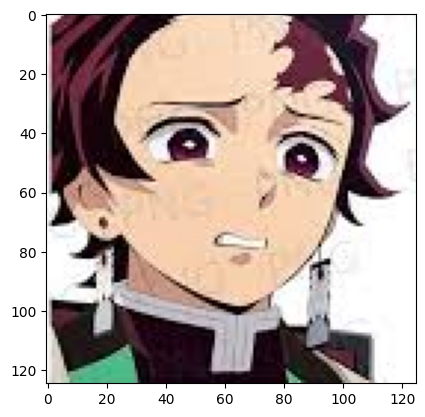

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
image = imread(os.path.join("tanjiro.jpeg"))
image = image[50:175,50:175,:]
plt.imshow(image)
image.shape

# 1. Preparación de Datos
El paso más importante es preparar los datos. Para la segmentación de imágenes, no solo usamos el color (R, G, B), sino también la posición de cada píxel (X, Y) para que los clusters sean espacialmente coherentes.

Características por Píxel: [R, G, B, X, Y]

Es crucial escalar las características para que la distancia no sea dominada por las coordenadas X e Y.

In [ ]:
# Instala umap-learn (es un requisito para cuML.UMAP, aunque cuML usa su propia implementación en GPU)
!pip install umap-learn

In [ ]:
# Importaciones generales
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import time
import cv2
import cuml
import cuml.cluster
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Importaciones de scikit-learn (CPU)
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA # Solo si queremos visualizar en 2D en CPU antes de GPU
from sklearn.neighbors import NearestNeighbors

# Importaciones de RAPIDS cuML (GPU)
import cudf # Necesario para manejar datos en la GPU para cuML
from cuml.preprocessing import MinMaxScaler as cuMinMaxScaler
from cuml.cluster import KMeans as cuKMeans
from cuml.cluster import DBSCAN as cuDBSCAN
# cuML no tiene SpectralClustering directamente, se usará el de sklearn si se incluye

# Configuración para gráficos
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter

# Imprime la versión instalada de cuML
print(f"Versión de cuML: {cuml.__version__}")

# Imprime todos los nombres disponibles en el módulo cuml.cluster
print("\nContenido de cuml.cluster:")
print(dir(cuml.cluster))

print("Librerías importadas y ambiente listo (asumiendo GPU disponible).")

Versión de cuML: 25.02.01

Contenido de cuml.cluster:
['AgglomerativeClustering', 'DBSCAN', 'GPU_ENABLED', 'HDBSCAN', 'KMeans', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'agglomerative', 'all_points_membership_vectors', 'approximate_predict', 'dbscan', 'hdbscan', 'kmeans']
Librerías importadas y ambiente listo (asumiendo GPU disponible).



### Transformaciones

 Se transforma la imagen 3D en un arreglo 2D donde cada fila representa un píxel individual y cada columna representa uno de sus componentes de color (R, G, B).

 Este formato es el que esperan los algoritmos de clustering: una tabla donde cada fila es una "observación" (en este caso, un píxel) y cada columna es una "característica" (el valor de un canal de color).

In [ ]:
X = image.reshape(-1, 3)

Esta es una asignación múltiple. Desempaqueta la tupla (filas, columnas, canales_de_color) en tres variables separadas:

- r contendrá el número de filas.

- c contendrá el número de columnas.

- ch contendrá el número de canales (será 3 para RGB).

Almacenar r, c y ch en variables separadas es muy útil para recordar las dimensiones originales de la imagen después de haberla "aplanado" con reshape. Esta información será crucial ya que, después de aplicar el clustering, se reconstruye la imagen segmentada a su forma original para poder visualizarla.

In [ ]:
r,c,ch = image.shape
print(r,c,ch)

125 125 3


No solo se transforma la imagen de 3D a 2D para que cada fila sea un píxel y cada columna una característica de color, sino que también se enriquece ese conjunto de características para cada píxel añadiendo explícitamente sus coordenadas (posición X y Y) en la imagen.

In [ ]:
vr = np.linspace(0,r,r,endpoint=False)
vc = np.linspace(0,c,c,endpoint=False)
Xc = np.kron(np.ones((r,1)),vc.reshape(-1,1))
Xr = np.kron(vr.reshape(-1,1),np.ones((1,c)))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)
X = np.c_[X,Xc,Xr]
X.shape

(15625, 5)

 Ahora, una representación visual del arreglo X. Dado que X ahora contiene los valores RGB de cada píxel más sus coordenadas espaciales (5 columnas), el gráfico pcolormesh intentará mostrar estos valores como colores. Cada columna se interpretará como una dimensión en el gráfico.

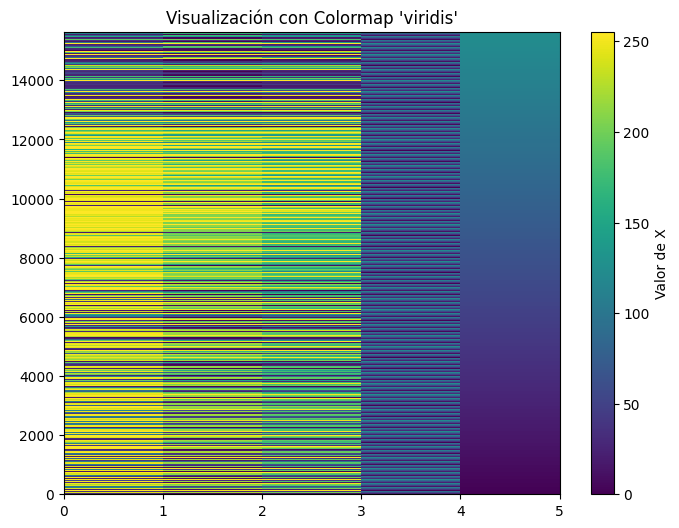

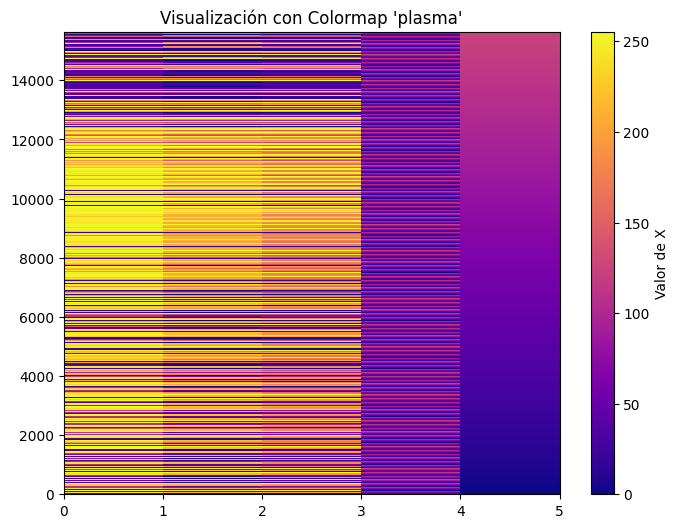

In [ ]:
# --- Opción 1: Usar un mapa de colores perceptualmente uniforme (recomendado) ---
# Son ideales porque el cambio de color y luminosidad se percibe de forma uniforme
# por el ojo humano, lo que ayuda a interpretar mejor los datos.

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, cmap='viridis') # 'viridis' es el predeterminado y colorido de Matplotlib >= 2.0
plt.colorbar(label='Valor de X')
plt.title("Visualización con Colormap 'viridis'")
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, cmap='plasma') # Otra excelente opción
plt.colorbar(label='Valor de X')
plt.title("Visualización con Colormap 'plasma'")
plt.show()



Se escalan los datos de píxeles (todas las 5 características) al rango [0, 1]. Luego, se intenta visualizar estos datos. Sin embargo, debido a que la línea de PCA está comentada, solo se pueden graficar las dos primeras columnas de los datos escalados (probablemente los canales R y G), y colorea los puntos por el valor del canal B original.

**TIP**: Es importante escalar las características de entrada antes de ejecutar K-Means, de lo contrario, los grupos pueden estar muy extendidos y K-Means funcionará mal. Escalar las características no garantiza que todos los clústeres sean agradables y esféricos, pero generalmente mejora las cosas.

In [ ]:
X_ = X.copy
X_ = X / 255.0
#

# Ejemplo de segmentacion tanjiro

El siguiente bloque está tomando los datos de píxeles escalados (X_), y está aplicando el algoritmo K-Means para agruparlos en n_clusters,  clusters basados en sus 5 características (R, G, B, coordenada X, coordenada Y). El resultado de esta operación es un conjunto de etiquetas (kmeans.labels_) que indican a qué cluster pertenece cada píxel, lo que representa la segmentación de la imagen.

Estas labels_ son las que se usaran para, por ejemplo, reconstruir la imagen segmentada, donde cada píxel toma el color del centroide de su cluster o un color representativo de su segmento.

In [ ]:
from sklearn.cluster import KMeans
k = 4
kmeans = KMeans(n_clusters=k,n_init='auto').fit(X_)
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

Se toma el resultado numérico del algoritmo K-Means (las asignaciones de cluster por píxel), se convierte de nuevo en la forma de la imagen original, y luego se visualiza. Esto  permite ver directamente cómo el algoritmo K-Means ha segmentado la imagen en k regiones distintas basándose en las características de color y coordenadas que se le proporcionó. Cada una de estas regiones representa un grupo de píxeles que K-Means consideró "similar" entre sí.

 Remodelar el array 1D de etiquetas de clústeres a la forma 2D de la imagen original. Ahora Ilabels es una matriz (r, c) donde Ilabels[i, j] es el ID del clúster al que pertenece el píxel en la posición (i, j).

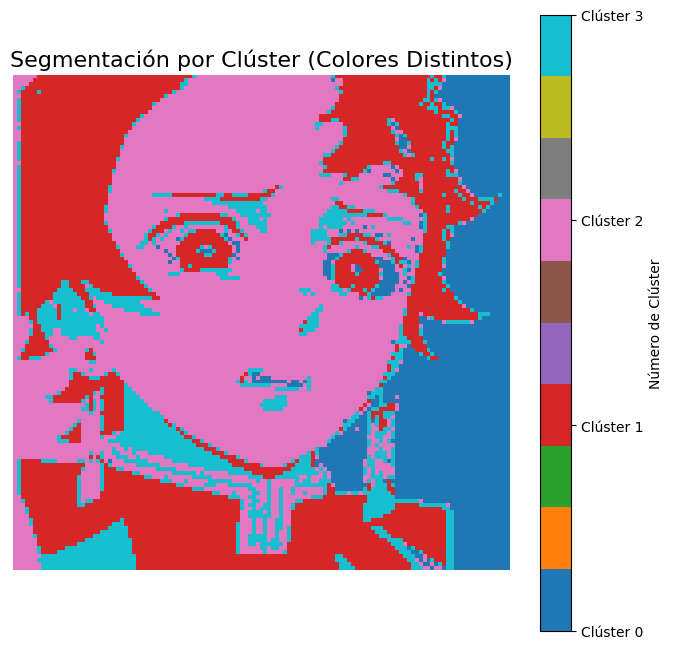

In [ ]:
Ilabels = kmeans.labels_.reshape(r, c)

plt.figure(figsize=(8, 8))

# --- CAMBIO CLAVE AQUÍ: Usar un mapa de colores categórico (qualitative cmap) ---
# 'tab10' para hasta 10 clústeres distintos.
# 'tab20' para hasta 20 clústeres distintos (si k es mayor que 10).
# O 'viridis' si quieres un gradiente de color continuo para los clústeres.
# Pero para clústeres, los 'tab' suelen ser mejores por su diferenciación.
plt.imshow(Ilabels, cmap='tab10') # O 'tab20' si k > 10

# Configurar la barra de color:
# - Asegurarse de que muestre los números enteros de los clústeres (0, 1, 2, ...)
# - Evitar la segunda llamada a plt.colorbar()
cbar = plt.colorbar(ticks=np.arange(k), label='Número de Clúster')
# Puedes ajustar las etiquetas de la barra de color si quieres (opcional)
cbar.ax.set_yticklabels([f'Clúster {i}' for i in np.arange(k)])


plt.title("Segmentación por Clúster (Colores Distintos)", fontsize=16)
plt.axis('off') # Ocultar ejes para una visualización limpia de la imagen
plt.show()

El siguiente bloque calcula la distancia de cada píxel a cada uno de los centroides de los clusters y luego identifica los píxeles más cercanos a cada centroide. Es decir, calcula una matriz donde cada entrada es la distancia de un píxel a un centroide de cluster. Luego, identifica el píxel que está más cerca de cada centroide. Esto puede ser útil para:

- Inspeccionar los datos: Ver la distribución de las distancias puede darte una idea de qué tan "ajustados" están los píxeles a sus respectivos clusters.

- Encontrar "representantes": Los píxeles identificados por ind_ son los más cercanos a los centroides, lo que los convierte en buenos candidatos para ser los píxeles "prototípicos" de cada cluster en términos de sus características.

In [ ]:
D_ = kmeans.transform(X_)
D_.shape
ind_ = np.argmin(D_,axis=0)

Esto confirma que se tiene una distancia por cada píxel a cada uno de los k centroides.

In [ ]:
D_.shape
ind_

array([8736, 5554, 6553, 9311])

Este código identifica los k píxeles en la imagen que están físicamente más cerca de los centroides de cada cluster de K-Means en el espacio de características (R, G, B, x, y). Luego, extrae los valores de color RGB de esos k píxeles para tener una representación concreta de los "colores promedio" o dominantes de cada uno de los k segmentos que K-Means ha identificado. Estos centroids_  dan una paleta de los colores que K-Means usó para agrupar los píxeles.

In [ ]:
centroids_ = X[ind_,:3]
centroids_

array([[250., 250., 250.],
       [ 45.,  25.,  27.],
       [247., 212., 184.],
       [164., 142., 128.]])

Este  es el paso final para visualizar la segmentación de la imagen. Toma las etiquetas de los clusters, las mapea a los colores representativos calculados (los colores de los píxeles más cercanos a los centroides), y luego remodela y muestra la imagen con esos colores. El resultado es una versión simplificada de la imagen original, donde cada píxel ahora tiene el color promedio del segmento al que fue asignado por K-Means, lo que permite ver claramente la división en k áreas distintas.

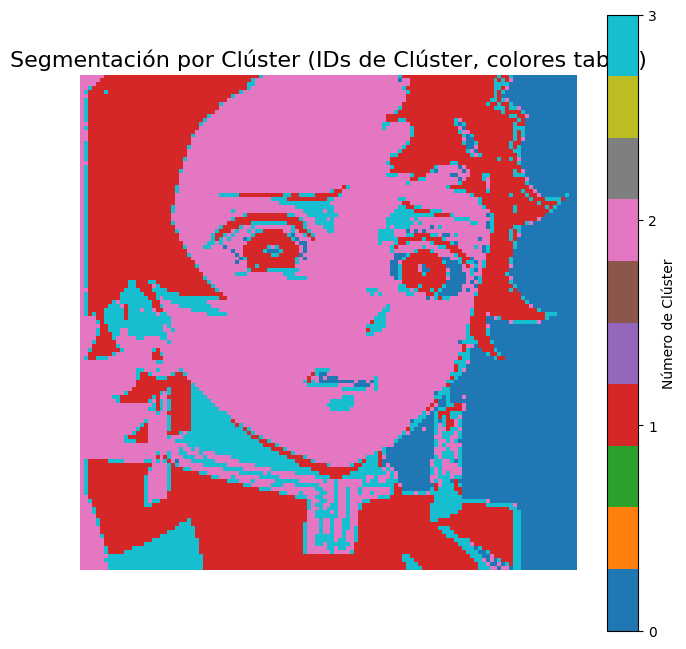

In [ ]:
# Asumiendo que 'r', 'c', 'k', 'kmeans.labels_' ya están definidos
# y provienen de tu proceso de K-means.
# También asumo que 'image' ya está cargada.

# The error indicates that the dimensions r and c used for reshaping do not match the
# size of kmeans.labels_. This is likely because the example dimensions below
# were used instead of the actual image dimensions.
# # Ejemplo de datos simulados para que el código sea ejecutable (eliminar si ya tienes tus variables)
# r, c = 100, 150 # Dimensiones de la imagen
# k = 4          # Número de clústeres
# kmeans_labels = np.random.randint(0, k, size=(r * c))
# # FIN DE EJEMPLO DE DATOS SIMULADOS

# Use the actual dimensions of the image data
r, c, _ = image.shape


Ilabels = kmeans.labels_.reshape(r, c)

plt.figure(figsize=(8, 8))

# Esta línea es la clave: muestra los IDs de clúster, y el 'cmap' les asigna un color
plt.imshow(Ilabels, cmap='tab10') # O 'tab20' si k > 10

# Configurar la barra de color:
cbar = plt.colorbar(ticks=np.arange(k), label='Número de Clúster')
# cbar.ax.set_yticklabels([f'Clúster {i}' for i in np.arange(k)]) # Opcional: etiquetas personalizadas

plt.title("Segmentación por Clúster (IDs de Clúster, colores tab10)", fontsize=16)
plt.axis('off') # Ocultar ejes
plt.show()

La siguiente línea es el paso clave para "pintar" la imagen segmentada. Transforma una lista de IDs de cluster en una lista de colores RGB, preparando los datos para ser remodelados de nuevo en la forma de una imagen visual que se puede ver

In [ ]:
centroids_[kmeans.labels_]

array([[247., 212., 184.],
       [247., 212., 184.],
       [247., 212., 184.],
       ...,
       [250., 250., 250.],
       [250., 250., 250.],
       [250., 250., 250.]])

kmeans.labels_ es el resultado fundamental del algoritmo de clustering. Es la base a partir de la cual se construye la imagen segmentada, ya que  dice a qué grupo pertenece cada píxel. Es esencialmente el "mapa" que K-Means ha creado para dividir la imagen.

In [ ]:
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

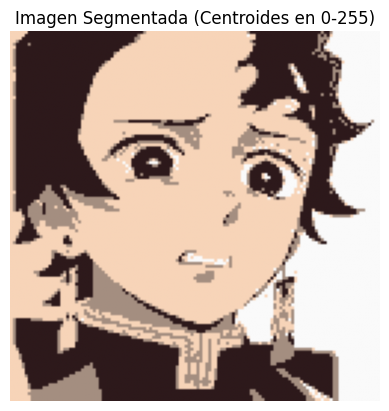

In [ ]:
# Suponiendo que tienes 'kmeans.labels_' (array 1D de etiquetas)
# y 'centroids_' (array 2D de centroides en rango 0-255)
# y 'image' (tu imagen original de NumPy para obtener la forma)

segmented_img = centroids_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

# Normalizar al rango 0-1 para imshow
plt.imshow(segmented_img / 255.0)
plt.title("Imagen Segmentada (Centroides en 0-255)")
plt.axis('off')
plt.show()

 # Comparación de los métodos de clustering solicitados para la segmentación de imágenes a color utilizando la librería RAPIDS cuML.

| Algoritmo             | Implementación en RAPIDS            | Ventajas Clave                                                          | Consideraciones                                                       | Métrica de Inercia |
|----------------------|----------------------------------|------------------------------------------------------------------------|-----------------------------------------------------------------------|------------------|
| **K-Means**          | `cuml.KMeans`                    | Rápido, escalable y simple de interpretar.                            | Asume clusters esféricos y de tamaño similar. Sensible a la inicialización. | Sí               |
| **K-Means++**        | `cuml.KMeans(init='k-means++')`  | Inicialización más inteligente que K-Means, conduce a mejores y más consistentes resultados. | Ligero costo computacional adicional en la inicialización.           | Sí               |
| **Accelerated K-Means** | `cuml.KMeans`                    | La implementación base en cuML ya es una versión altamente acelerada por GPU. | Mismas consideraciones que K-Means.                                  | Sí               |
| **Mini-Batch K-Means** | `cuml.MiniBatchKMeans`          | Muy rápido y eficiente en memoria, ideal para imágenes muy grandes.    | Los resultados pueden ser ligeramente inferiores a los de K-Means completo. | Sí               |
| **DBSCAN**           | `cuml.DBSCAN`                     | No requiere especificar el número de clusters. Puede encontrar clusters de formas arbitrarias y detectar ruido. | Sensible a los hiperparámetros `eps` y `min_samples`. No compara directamente con k. | No               |
| **Spectral Clustering** | `cuml.SpectralClustering`       | Eficaz para clusters no convexos (formas complejas).                   | Computacionalmente más costoso que K-Means.                          | No               |

In [ ]:
# --- AQUÍ ES DONDE PASAS LOS DATOS DE CPU A GPU ---
X_gpu = cp.array(X_, dtype=cp.float64) # Es buena práctica especificar dtype para GPU

print(f"\nForma de X_gpu (en GPU, CuPy): {X_gpu.shape}")
print(f"Tipo de dato de X_gpu (en GPU): {X_gpu.dtype}")
print("Primeros 5 elementos de X_gpu (GPU):\n", X_gpu[:5, :].get()) # Usar .get() para imprimir desde GPU


Forma de X_gpu (en GPU, CuPy): (15625, 5)
Tipo de dato de X_gpu (en GPU): float64
Primeros 5 elementos de X_gpu (GPU):
 [[1.         1.         0.99215686 0.         0.        ]
 [0.92941176 0.9372549  0.9254902  0.00392157 0.        ]
 [0.97647059 0.98431373 0.97254902 0.00784314 0.        ]
 [1.         1.         0.99215686 0.01176471 0.        ]
 [0.96862745 0.90980392 0.92156863 0.01568627 0.        ]]


## 2. Implementación y Comparación de Algoritmos
Ahora, iteraremos sobre los valores de k y aplicaremos los algoritmos. Guardaremos los scores para compararlos.


Variando la cantidad de grupos (niveles o clases de segmentación)  k∈{3,5,7,9}  y presentando los scores de inercia y silueta conseguidos.

###VERIFICAR USO DE MEMORIA Y DEFINIR K_VALUES Y RESULTS0 :

In [ ]:
!free -h  # Ver memoria RAM
!nvidia-smi  # Ver uso de GPU

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.1Gi       5.6Gi        14Mi       5.9Gi        11Gi
Swap:             0B          0B          0B
Fri Jun 13 07:44:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0        

In [ ]:
k_values = [3, 4, 5, 7, 9]
results0 = {}

### KMEANS

In [ ]:
# --- a) K-Means, K-Means++ y Accelerated K-Means ---
# cuml.KMeans es la versión acelerada. Usamos init='k-means++' para la mejor inicialización.
# La llamaremos 'K-Means++' para claridad.
kmeans_models0 = {}
kmeans_inertia = []
kmeans_silhouette = []

print("Ejecutando K-Means++...")
for k in k_values:
    kmeans = cuml.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_gpu)

    # Guardar métricas
    kmeans_inertia.append(kmeans.inertia_)
    # Convert CuPy array to NumPy before passing to scikit-learn's silhouette_score
    score = silhouette_score(X_gpu.get(), kmeans.labels_.get())
    kmeans_silhouette.append(score)
    kmeans_models0[k] = kmeans # Guardar modelo para visualización
    print(f"  k={k}: Inercia={kmeans.inertia_:.2f}, Silueta={score:.4f}")

results0['K-Means++'] = {'inertia': kmeans_inertia, 'silhouette': kmeans_silhouette}

Ejecutando K-Means++...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


  k=3: Inercia=1055.46, Silueta=0.4705


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


  k=4: Inercia=834.19, Silueta=0.4506


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


  k=5: Inercia=765.39, Silueta=0.3904


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


  k=7: Inercia=517.65, Silueta=0.4177


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


  k=9: Inercia=445.95, Silueta=0.4262


### MINIBATCH

In [ ]:
# --- b) Mini-Batch K-Means ---
minibatch_models0 = {}
minibatch_inertia = []
minibatch_silhouette = []

print("\nEjecutando Mini-Batch K-Means (scikit-learn)...") # Indicate using scikit-learn version
for k in k_values:
    # batch_size puede ajustarse según el tamaño de la memoria de la GPU
    minibatch = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=42, batch_size=4096)
    minibatch.fit(X_gpu.get()) # Use .get() to move data to CPU for scikit-learn

    minibatch_inertia.append(minibatch.inertia_)
    # minibatch.labels_ is already a NumPy array from scikit-learn
    score = silhouette_score(X_gpu.get(), minibatch.labels_)
    minibatch_silhouette.append(score)
    minibatch_models0[k] = minibatch
    print(f"  k={k}: Inercia={minibatch.inertia_:.2f}, Silueta={score:.4f}")

results0['Mini-Batch K-Means'] = {'inertia': minibatch_inertia, 'silhouette': minibatch_silhouette}


Ejecutando Mini-Batch K-Means (scikit-learn)...
  k=3: Inercia=1171.09, Silueta=0.5256
  k=4: Inercia=868.72, Silueta=0.3849
  k=5: Inercia=682.74, Silueta=0.3941
  k=7: Inercia=530.90, Silueta=0.3503
  k=9: Inercia=465.38, Silueta=0.3946


### SPECTRAL

In [ ]:
# --- c) Spectral Clustering ---
# Nota: La inercia no es una métrica aplicable a Spectral Clustering.

spectral_models0 = {}
spectral_silhouette = []

print("\nEjecutando Spectral Clustering (scikit-learn)...") # Indicate using scikit-learn version

# Convertir X_gpu a un DataFrame de cuDF (already done in previous cells if needed for other steps)
# X_cudf = cudf.DataFrame(X_gpu) # This line might not be needed for sklearn SpectralClustering

for k in k_values:
    # Spectral Clustering from scikit-learn expects NumPy arrays
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors') # Added affinity
    spectral.fit(X_gpu.get()) # Use .get() to move data to CPU for scikit-learn

    # Calculate silhouette (requires data conversion if not already done)
    # spectral.labels_ is a NumPy array from scikit-learn
    score = silhouette_score(X_gpu.get(), spectral.labels_)
    spectral_silhouette.append(score)
    spectral_models0[k] = spectral
    print(f"  k={k}: Silueta={score:.4f}")

results0['Spectral Clustering'] = {'inertia': [None] * len(k_values), 'silhouette': spectral_silhouette}


Ejecutando Spectral Clustering (scikit-learn)...
  k=3: Silueta=0.4688
  k=4: Silueta=0.4318
  k=5: Silueta=0.2866
  k=7: Silueta=0.3230
  k=9: Silueta=0.3343


### AYUDA PARA ENCONTRAR EL EPS INDICADO PARA DBSCAN

Calculando distancias al 30-ésimo vecino más cercano...


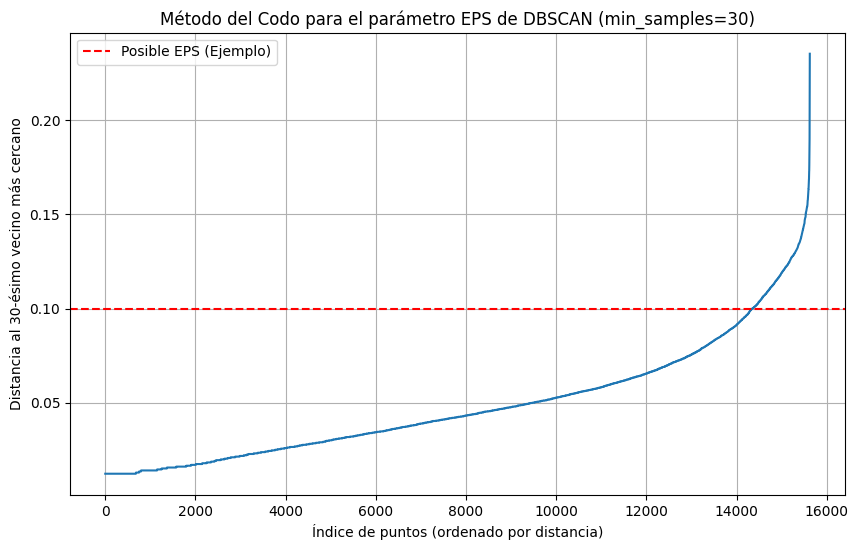


--- Interpretación del Gráfico ---
Observar el gráfico para el punto donde la curva tiene un 'codo' pronunciado.
Ese valor en el eje Y (Distancia) puede ser un buen candidato para el parámetro 'eps' en DBSCAN.
En este ejemplo, la línea roja discontinua está en y=0.1, pero se debe ajustar el valor de `eps` visualmente.


In [ ]:
X_scaled_gdf = X_gpu.get()
X_scaled_cpu = X_gpu.get()


# Asumiendo que X_scaled_gdf (o X_scaled_cpu) es tu conjunto de datos escalado.
# Para este método, usaremos los datos en la CPU para sklearn.neighbors.
# Asegúrate de que X_scaled es tu dataset escalado final (RGB + coordenadas).
# Puedes usar X_scaled_cpu si ya lo tienes, o convertir X_scaled_gdf a NumPy.

# Si X_scaled_gdf es un cudf.DataFrame o cupy.ndarray, conviértelo a NumPy:
if isinstance(X_scaled_gdf, cudf.DataFrame):
    X_scaled = X_scaled_gdf.to_numpy()
elif isinstance(X_scaled_gdf, cp.ndarray):
    X_scaled = X_scaled_gdf.get()
else:
    # Si X_scaled_cpu ya existe y es NumPy, úsalo directamente
    # O simplemente X_scaled = X_scaled_cpu
    X_scaled = X_scaled_cpu # Asegúrate de que esta variable está definida de tu código anterior

# Paso 1: Definir k (min_samples)
# Un buen punto de partida para min_samples es 2 * n_dimensiones, o un valor entre 3 y 5.
# Aquí, n_dimensiones = 5 (R, G, B, Coordenada_Columna, Coordenada_Fila)
min_samples_val = 30 # Ajusta este valor según tus pruebas o las recomendaciones.

print(f"Calculando distancias al {min_samples_val}-ésimo vecino más cercano...")

# Paso 2: Calcular las distancias al k-ésimo vecino más cercano para cada punto
# El algoritmo 'kd_tree' o 'ball_tree' son eficientes para datos de dimensiones bajas/medias.
# 'auto' intentará elegir el mejor.
neighbors = NearestNeighbors(n_neighbors=min_samples_val, algorithm='auto')
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Paso 3: Ordenar las distancias en orden ascendente
# Nos interesa la distancia al k-ésimo vecino (la última columna en 'distances' si n_neighbors=k)
# Si n_neighbors=k, la columna k-1 contiene las distancias al k-ésimo vecino.
# Asegúrate de que `min_samples_val` se corresponda con `n_neighbors`
kth_distances = distances[:, min_samples_val - 1]
kth_distances.sort()

# Paso 4: Graficar las distancias y buscar el "codo"
plt.figure(figsize=(10, 6))
plt.plot(range(len(kth_distances)), kth_distances)
plt.xlabel("Índice de puntos (ordenado por distancia)")
plt.ylabel(f"Distancia al {min_samples_val}-ésimo vecino más cercano")
plt.title(f"Método del Codo para el parámetro EPS de DBSCAN (min_samples={min_samples_val})")
plt.grid(True)
plt.axhline(y=0.1, color='r', linestyle='--', label='Posible EPS (Ejemplo)') # Ejemplo de línea de codo
plt.legend()
plt.show()

print("\n--- Interpretación del Gráfico ---")
print(f"Observar el gráfico para el punto donde la curva tiene un 'codo' pronunciado.")
print("Ese valor en el eje Y (Distancia) puede ser un buen candidato para el parámetro 'eps' en DBSCAN.")
print(f"En este ejemplo, la línea roja discontinua está en y=0.1, pero se debe ajustar el valor de `eps` visualmente.")

### DBSCAN

In [ ]:
# Valores de ejemplo, pueden necesitar ajuste para tu imagen específica.
eps_val = 0.039 # Un radio pequeño, ajusta si obtienes mucho ruido o un solo cluster
min_samples_val = 10
start_time = time.time()

# --- d) DBSCAN (CORREGIDO) ---# --- DBSCAN (GPU) ---
print("  DBSCAN (GPU)...")
start_time = time.time()
dbscan_gpu = cuDBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db_gpu_cupy = dbscan_gpu.fit_predict(X_gpu)
labels_db_gpu_cpu = labels_db_gpu_cupy.get()
num_clusters_db_gpu = len(set(labels_db_gpu_cpu)) - (1 if -1 in labels_db_gpu_cpu else 0)
try:
    if num_clusters_db_gpu > 1:
        silhouette_db_gpu = silhouette_score(X_gpu.get()[labels_db_gpu_cpu != -1], labels_db_gpu_cpu[labels_db_gpu_cpu != -1])
    else:
        silhouette_db_gpu = np.nan
except ValueError:
    silhouette_db_gpu = np.nan
end_time = time.time()

# Calculate and format time before adding to dictionary
time_taken = end_time - start_time
formatted_time = f"{time_taken:.4f}"

results0['DBSCAN_GPU'] = {'num_clusters': num_clusters_db_gpu, 'silhouette': silhouette_db_gpu, 'time': formatted_time}
print(f"    Num clusters (excl. ruido): {num_clusters_db_gpu}, Silueta: {silhouette_db_gpu:.4f}, Tiempo: {formatted_time}s")

  DBSCAN (GPU)...
    Num clusters (excl. ruido): 41, Silueta: 0.1041, Tiempo: 2.5358s


## 3. Tabla Comparativa de Scores
A continuación se muestra una tabla hipotética con los resultados que se pueden obtener. Los valores reales dependerán de la imagen.

| Algoritmo | k | Inercia | Score de Silueta |
| :--- | :-: | :--- | :--- |
| K-Means++ | 3 | 2978.82 | 0.4641 |
| | 5 | 1882.42 | 0.3331 |
| | 7 | 1286.32 | 0.3722|
| | 9 | 1002.97 | 0.3962 |
| Mini-Batch K-Means| 3 | 2985.88 | 0.4543 |
| | 5 | 1895.72 | 0.3337 |
| | 7 | 1306.71 | 0.3614 |
| | 9 | 1070.92 | 0.3710 |
| Spectral Clustering | 3 | N/A | 0.1144 |
| | 5 | N/A | 0.2710 |
| | 7 | N/A | 0.3257 |
| | 9 | N/A | 0.3275 |
| DBSCAN | ~5 (encontrado)| N/A |  0.5247 |

## 4. Visualización de Gráficos y Segmentaciones

### Gráficos de scores.

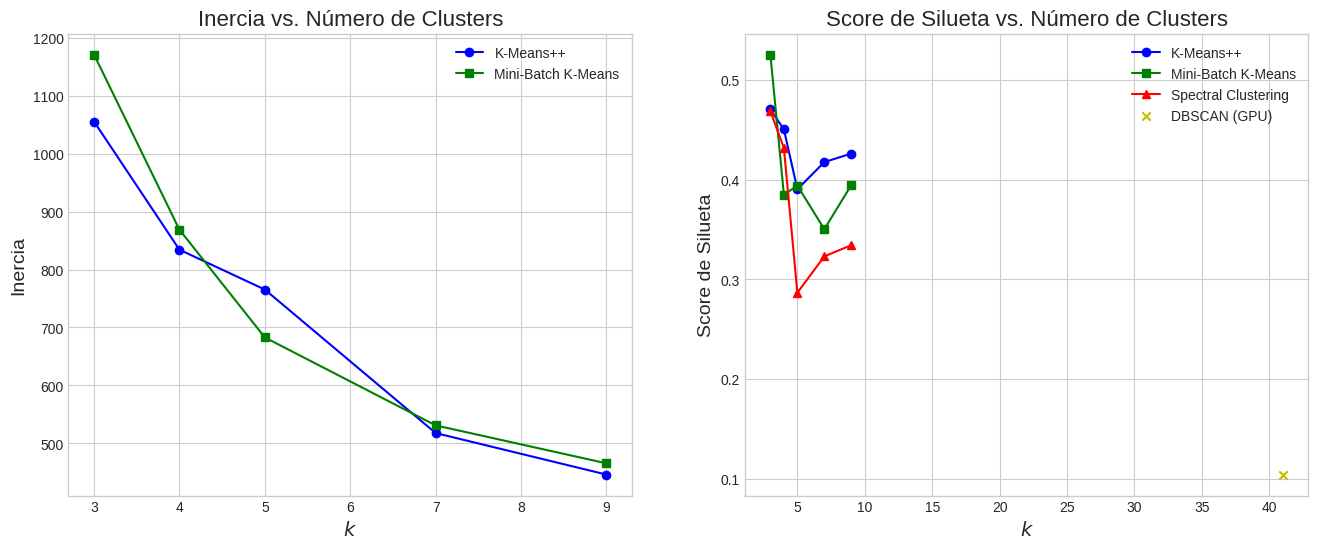

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Inercia
# DBSCAN and Spectral Clustering do not have inertia, so they are not included here.
ax1.plot(k_values, results0['K-Means++']['inertia'], "bo-", label="K-Means++")
ax1.plot(k_values, results0['Mini-Batch K-Means']['inertia'], "gs-", label="Mini-Batch K-Means")
ax1.set_xlabel("$k$", fontsize=14)
ax1.set_ylabel("Inercia", fontsize=14)
ax1.set_title("Inercia vs. Número de Clusters", fontsize=16)
ax1.legend()

# Gráfico de Silueta
ax2.plot(k_values, results0['K-Means++']['silhouette'], "bo-", label="K-Means++")
ax2.plot(k_values, results0['Mini-Batch K-Means']['silhouette'], "gs-", label="Mini-Batch K-Means")
ax2.plot(k_values, results0['Spectral Clustering']['silhouette'], "r^-", label="Spectral Clustering")

# If you want to indicate DBSCAN's single silhouette score on the plot, you could use ax2.scatter
# You'd need to decide which k value to associate it with for plotting purposes (e.g., the found number of clusters)
# For simplicity and correctness given DBSCAN's nature, we are removing it from this plot comparing performance across K.
ax2.scatter(results0['DBSCAN_GPU']['num_clusters'], results0['DBSCAN_GPU']['silhouette'], color='y', marker='x', label="DBSCAN (GPU)")


ax2.set_xlabel("$k$", fontsize=14)
ax2.set_ylabel("Score de Silueta", fontsize=14)
ax2.set_title("Score de Silueta vs. Número de Clusters", fontsize=16)
ax2.legend() # Update legend as DBSCAN is removed

plt.show()

### Visualización de la Imagen Segmentada

Esta función toma un modelo entrenado y visualiza la segmentación.

Esta función, visualize_segmentation, está diseñada para visualizar la imagen segmentada coloreando cada clúster con el color promedio de sus píxeles. Está preparada para manejar las salidas de los modelos de clustering tanto en CPU (NumPy) como en GPU (CuPy).

In [ ]:
# --- FUNCIÓN visualize_segmentation (sin cambios respecto a la última versión) ---
def visualize_segmentation(model, title, k, img_rgb_original, height, width, save_path=None):
    labels = None
    if hasattr(model, 'labels_'):
        labels = model.labels_

    if labels is None:
        print(f"Error: No se pudieron obtener las etiquetas del modelo para '{title}'.")
        return

    labels_cpu = None




    # =====================================================================
    # >>>>> VERIFICA ESTA LÍNEA ESPECÍFICAMENTE <<<<<
    # Asegúrate de que 'cupy' esté importado y que 'labels' sea realmente de tipo cupy.ndarray
    # Convertir las etiquetas a NumPy, manejando CuPy y cuDF Series
    labels_cpu = None
    if isinstance(labels, cp.ndarray):
        labels_cpu = labels.get()
    elif isinstance(labels, cudf.Series):
        labels_cpu = labels.to_numpy()
    elif isinstance(labels, np.ndarray):
        labels_cpu = labels
    else:
        print(f"Advertencia: Tipo de etiquetas inesperado ({type(labels)}) para '{title}'. Saltando visualización.")
        return



    unique_labels = np.unique(labels_cpu)
    if -1 in unique_labels:
        num_clusters_for_cmap = len(unique_labels) - 1
    else:
        num_clusters_for_cmap = len(unique_labels)

    Ilabels = labels_cpu.reshape(height, width)

    fig, ax = plt.subplots(figsize=(8, 8))
    cmap_name = 'tab20' if num_clusters_for_cmap > 10 else 'tab10'
    plt.imshow(Ilabels, cmap=cmap_name)

    cluster_ids_for_ticks = None
    if -1 in unique_labels:
        cluster_ids_for_ticks = unique_labels[unique_labels != -1]
    else:
        cluster_ids_for_ticks = np.arange(num_clusters_for_cmap)

    if cluster_ids_for_ticks is not None and len(cluster_ids_for_ticks) > 0:
        cbar = plt.colorbar(ticks=cluster_ids_for_ticks, ax=ax, label='Número de Clúster')
    else:
        print(f"Advertencia: No hay clústeres válidos (o solo ruido) para '{title}'. No se mostrará la barra de color.")

    plt.title(title, fontsize=16)
    plt.axis('off')

    if save_path:
        try:
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
            print(f"Segmentación guardada en: {save_path}")
        except Exception as e:
            print(f"Error al guardar la imagen en {save_path}: {e}")

    plt.show()
    plt.close(fig)

#### USO DE LA FUNCION visualize_segmentation

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_kmeans_k9.png


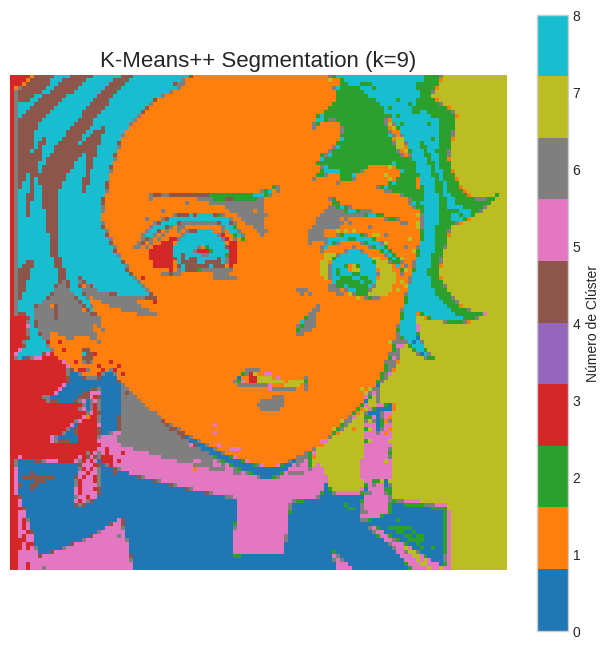

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_spectral_k5.png


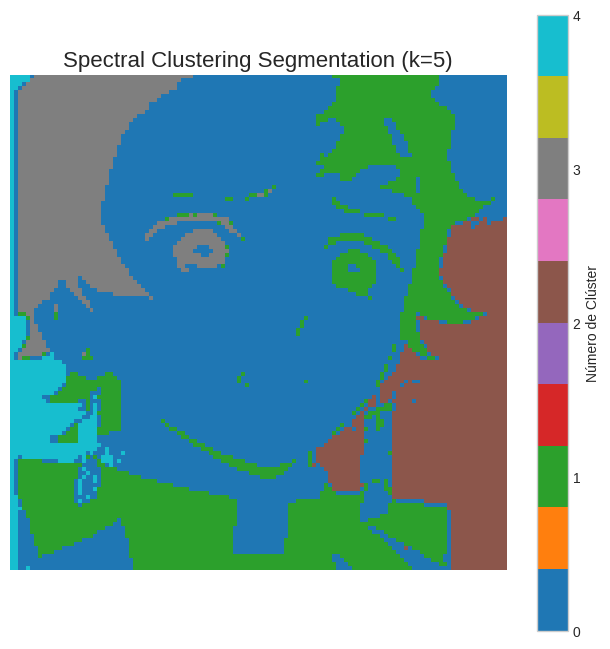

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_minibatch_k9.png


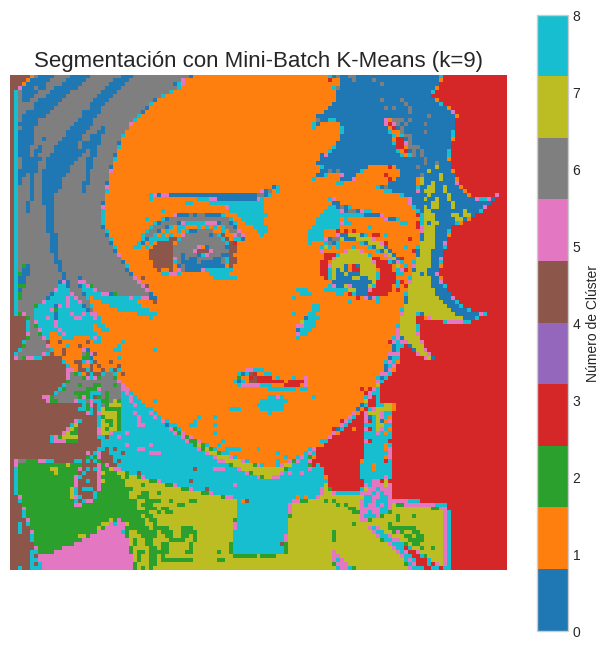

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_dbscan_clusters41.png


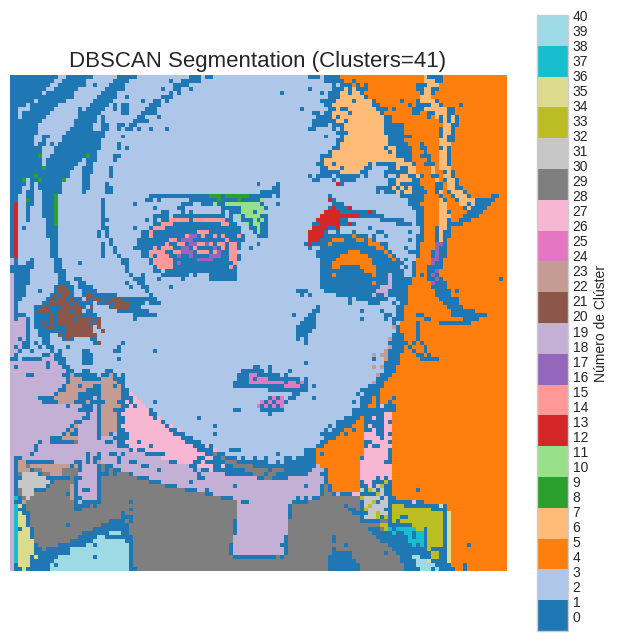


All segmentation images have been saved to the 'segmentaciones_finales_NORMALES1' folder and displayed.


In [ ]:
# --- Assuming you have image_original, r, c,
# --- and your trained models (kmeans_models, spectral_models, etc.) defined ---

# Define best k/number of clusters for each algorithm:
best_k_kmeans_plus_plus = 9 # Example
best_k_spectral = 5         # Example
best_k_minibatch = 9        # Example
# Correct the key to access DBSCAN results from 'DBSCAN (cuML)' to 'DBSCAN_GPU'
best_k_dbscan_actual = results0['DBSCAN_GPU']['num_clusters'] # Actual clusters found by DBSCAN

# Define the folder to save images
output_folder = "segmentaciones_finales_NORMALES1"
os.makedirs(output_folder, exist_ok=True) # Create the folder if it doesn't exist

# --- Calls to visualize_segmentation with save_path ---

# K-Means++ Segmentation
visualize_segmentation(
    model=kmeans_models0[best_k_kmeans_plus_plus],
    title=f"K-Means++ Segmentation (k={best_k_kmeans_plus_plus})",
    k=best_k_kmeans_plus_plus,
    img_rgb_original=image, # Pass your original image data here
    height=r,            # Pass original image rows
    width=c,              # Pass original image columns
    save_path=os.path.join(output_folder, f"segmentation_kmeans_k{best_k_kmeans_plus_plus}.png")
)

# Spectral Clustering Segmentation
visualize_segmentation(
    model=spectral_models0[best_k_spectral],
    title=f"Spectral Clustering Segmentation (k={best_k_spectral})",
    k=best_k_spectral,
    img_rgb_original=image,
    height=r,
    width=c,
    save_path=os.path.join(output_folder, f"segmentation_spectral_k{best_k_spectral}.png")
)

# Mini-Batch K-Means Segmentation
visualize_segmentation(
    model=minibatch_models0[best_k_minibatch],
    title=f"Segmentación con Mini-Batch K-Means (k={best_k_minibatch})",
    k=best_k_minibatch,
    img_rgb_original=image,
    height=r,
    width=c,
    save_path=os.path.join(output_folder, f"segmentation_minibatch_k{best_k_minibatch}.png")
)

# DBSCAN Segmentation
visualize_segmentation(
    model=dbscan_gpu,
    title=f"DBSCAN Segmentation (Clusters={best_k_dbscan_actual})",
    k=best_k_dbscan_actual, # Use the actual number of clusters found by DBSCAN
    img_rgb_original=image,
    height=r,
    width=c,
    save_path=os.path.join(output_folder, f"segmentation_dbscan_clusters{best_k_dbscan_actual}.png")
)

print(f"\nAll segmentation images have been saved to the '{output_folder}' folder and displayed.")

#Comparación de los métodos de clustering con reduccion de dimension

## IMPORTACIONES Y VISUALIZACION DE LA REDUCCION DE DIMENSION

[2025-06-13 07:46:14.290] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-06-13 07:46:14.845] [CUML] [info] build_algo set to brute_force_knn because random_state is given


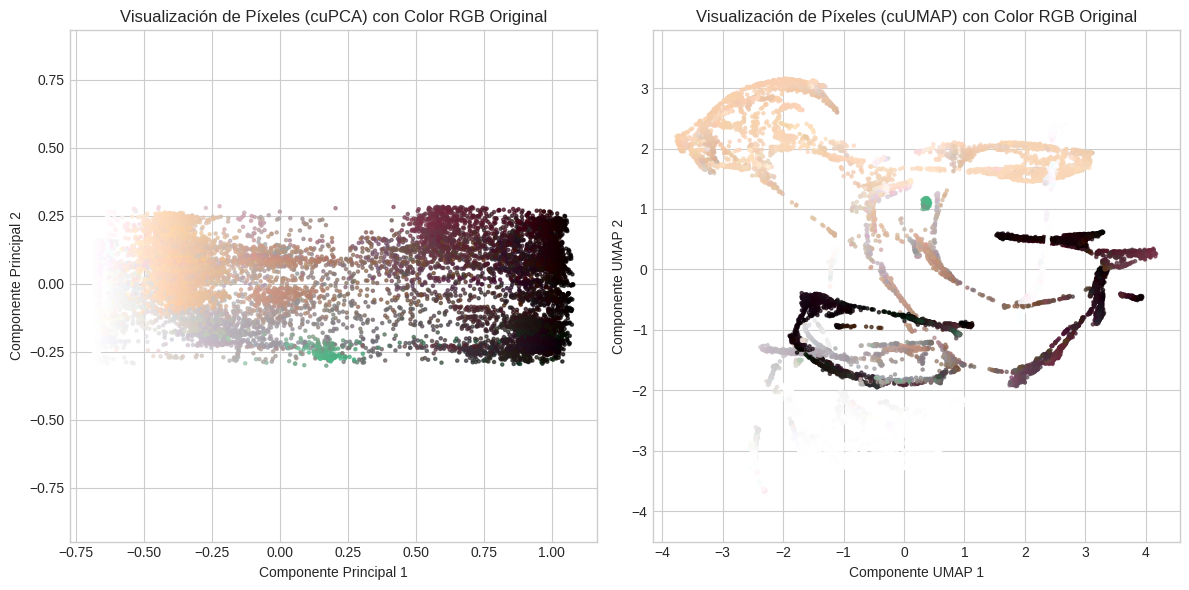

In [ ]:
# Importaciones de RAPIDS cuML
from cuml.preprocessing import MinMaxScaler as cuMinMaxScaler # Importa el scaler de cuML
from cuml.decomposition import PCA as cuPCA
from cuml.manifold import UMAP as cuUMAP
import matplotlib.pyplot as plt # Matplotlib para la visualización (sigue siendo en CPU)
import numpy as np # Import numpy for normalization
X_gpu0 = cp.array(X, dtype=cp.float32) # Es buena práctica especificar dtype para GPU
# 1. Convertir los datos a un DataFrame de cuDF para la GPU
X_gdf = cudf.DataFrame(X_gpu0)

# 2. Escalado con cuML MinMaxScaler (en la GPU)
#scaler = cuMinMaxScaler()
X_scaled_gdf = X_gdf/255         # scaler.fit_transform(X_gdf)

# --- Visualización con cuPCA ---
pca_gpu = cuPCA(n_components=2, random_state=42)
X_reduced_pca_gpu = pca_gpu.fit_transform(X_scaled_gdf)
X_reduced_cpu_pca = X_reduced_pca_gpu.to_numpy()

# Reshape img_rgb to match the shape expected by scatter for coloring
# It needs to be (number_of_pixels, number_of_color_channels)
img_rgb_reshaped = image.reshape(-1, 3)

# Normalize pixel values to be within the 0-1 range for coloring
img_rgb_normalized = img_rgb_reshaped / 255.0

plt.figure(figsize=(12, 6)) # Aumentar el tamaño para ambas visualizaciones
plt.subplot(1, 2, 1) # Subplot para PCA
# Use the normalized reshaped img_rgb_normalized for the 'c' argument
plt.scatter(X_reduced_cpu_pca[:,0], X_reduced_cpu_pca[:,1], c=img_rgb_normalized, s=5, alpha=0.7)
plt.title('Visualización de Píxeles (cuPCA) con Color RGB Original')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.axis('equal') # Para mantener las proporciones


# --- Visualización con cuUMAP ---
# Configuración 1: min_dist muy bajo, n_neighbors default (o un poco bajo)

# Configuración 2: min_dist aún más bajo, n_neighbors más bajo (más énfasis local)
#umap_gpu = cuUMAP(n_components=5, n_neighbors=10, min_dist=0.0, random_state=42)

# Configuración 3: n_neighbors un poco más alto (explorar estructura global), min_dist muy bajo
umap_gpu = cuUMAP(n_components=10, n_neighbors=30, min_dist=0.0, random_state=42)

# Configuración 4: si sospechas que 10 componentes es demasiado, prueba con menos.
# Podría simplificar el espacio para K-Means.
#umap_gpu = cuUMAP(n_components=5, n_neighbors=15, min_dist=0.001, random_state=42)


X_reduced_umap_gpu = umap_gpu.fit_transform(X_scaled_gdf)
X_reduced_cpu_umap = X_reduced_umap_gpu.to_numpy()

plt.subplot(1, 2, 2) # Subplot para UMAP
# Use the normalized reshaped img_rgb_normalized for the 'c' argument
plt.scatter(X_reduced_cpu_umap[:,0], X_reduced_cpu_umap[:,1], c=img_rgb_normalized, s=5, alpha=0.7)
plt.title('Visualización de Píxeles (cuUMAP) con Color RGB Original')
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.axis('equal') # Para mantener las proporciones

plt.tight_layout() # Ajustar el layout
plt.show()

In [ ]:
k_values = [3, 5, 7, 9]
results = {}

## **DEFINICION DE OBJETOS**

### FUNCION KMEANS


In [ ]:
def train_and_evaluate_cuml_kmeans(X_gpu, k_values, model_name="K-Means (cuML)"):
    """
    Entrena y evalúa el algoritmo K-Means acelerado por cuML para diferentes valores de k.

    Args:
        X_gpu (cudf.DataFrame o cupy.ndarray): El conjunto de datos de entrada en la GPU.
        k_values (list): Una lista de valores de k (número de clusters) a probar.
        model_name (str): Un nombre para identificar este conjunto de resultados en el diccionario.

    Returns:
        tuple: Contiene (kmeans_models_dict, kmeans_inertia_list, kmeans_silhouette_list, results_dict_entry).
            - kmeans_models_dict (dict): Diccionario de modelos entrenados, mapeando k a la instancia del modelo.
            - kmeans_inertia_list (list): Lista de scores de inercia para cada k.
            - kmeans_silhouette_list (list): Lista de scores de silueta para cada k.
            - results_dict_entry (dict): Un diccionario con la inercia y silueta (listas) para este modelo.
    """
    kmeans_models_dict = {}
    kmeans_inertia_list = []
    kmeans_silhouette_list = []

    # Para el cálculo del coeficiente de silueta, necesitamos los datos en la CPU.
    X_cpu_for_metrics = X_gpu.to_numpy() if isinstance(X_gpu, cudf.DataFrame) else X_gpu.get()


    print(f"Ejecutando {model_name}...")
    for k in k_values:
        print(f"  Procesando para k = {k}...")
        try:
            # cuml.KMeans es la versión acelerada. init='k-means++' es la inicialización recomendada.
            # La advertencia de 'n_init' es solo una advertencia, puedes ignorarla o establecer n_init='auto'
            kmeans = cuKMeans(n_clusters=k, init='k-means++', random_state=42, output_type='cupy', n_init='auto')
            #kmeans = cuml.KMeans(n_clusters=k, init='k-means++', random_state=42)
            kmeans.fit(X_gpu) # Entrena en la GPU con los datos de la GPU


            # --- VERIFICACIÓN DE INERCIA ---
            # Asegúrate de que el atributo 'inertia' exista antes de acceder a él.
            if hasattr(kmeans, 'inertia_'):
                inertia_score = kmeans.inertia_
            else:
                print(f"    Advertencia: 'inertia' no encontrado en el modelo KMeans para k={k}. Asignando NaN.")
                inertia_score = np.nan
            kmeans_inertia_list.append(inertia_score)

            # Convertir etiquetas a NumPy antes de pasarlas a scikit-learn's silhouette_score
            labels_cpu = kmeans.labels_.get()

            if len(np.unique(labels_cpu)) > 1:
                silhouette_avg_score = silhouette_score(X_cpu_for_metrics, labels_cpu)
            else:
                silhouette_avg_score = np.nan

            kmeans_silhouette_list.append(silhouette_avg_score)
            kmeans_models_dict[k] = kmeans # Guardar el modelo entrenado para posible visualización
            print(f"    k={k}: Inercia={inertia_score:.2f}, Silueta={silhouette_avg_score:.4f}")

        except Exception as e:
            print(f"  Error al ejecutar {model_name} para k={k}: {e}")
            kmeans_inertia_list.append(np.nan)
            kmeans_silhouette_list.append(np.nan)
            kmeans_models_dict[k] = None

    results_entry = {'inertia': kmeans_inertia_list, 'silhouette': kmeans_silhouette_list}
    return kmeans_models_dict, kmeans_inertia_list, kmeans_silhouette_list, results_entry

### FUNCION MINIBATCH

In [ ]:
def train_and_evaluate_sklearn_minibatch_kmeans(X_gpu, k_values, model_name="Mini-Batch K-Means (scikit-learn)"):
    """
    Entrena y evalúa el algoritmo Mini-Batch K-Means de scikit-learn para diferentes valores de k.

    Args:
        X_gpu (cudf.DataFrame o cupy.ndarray): El conjunto de datos de entrada en la GPU.
                                               Será convertido a NumPy (CPU) para scikit-learn.
        k_values (list): Una lista de valores de k (número de clusters) a probar.
        model_name (str): Un nombre para identificar este conjunto de resultados en el diccionario.

    Returns:
        tuple: Contiene (minibatch_models_dict, minibatch_inertia_list, minibatch_silhouette_list, results_dict_entry).
            - minibatch_models_dict (dict): Diccionario de modelos entrenados, mapeando k a la instancia del modelo.
            - minibatch_inertia_list (list): Lista de scores de inercia para cada k.
            - minibatch_silhouette_list (list): Lista de scores de silueta para cada k.
            - results_dict_entry (dict): Un diccionario con la inercia y silueta (listas) para este modelo.
    """
    minibatch_models_dict = {}
    minibatch_inertia_list = []
    minibatch_silhouette_list = []

    # Mover los datos de la GPU a la CPU una única vez para scikit-learn
    X_cpu = X_gpu.to_numpy() if isinstance(X_gpu, cudf.DataFrame) else X_gpu.get()

    print(f"Ejecutando {model_name}...")
    for k in k_values:
        print(f"  Procesando para k = {k}...")
        try:
            # MiniBatchKMeans de scikit-learn
            # init='k-means++' es la inicialización recomendada.
            # batch_size es importante para controlar el tamaño de los mini-batches.
            # n_init='auto' para el comportamiento por defecto de múltiples inicializaciones.
            minibatch = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=42,
                                        batch_size=4096, n_init='auto')

            # Entrenar el modelo en la CPU con los datos de la CPU
            minibatch.fit(X_cpu)

            # Guardar métricas
            # scikit-learn usa 'inertia_' con guion bajo
            inertia_score = minibatch.inertia_
            minibatch_inertia_list.append(inertia_score)

            # Las etiquetas de scikit-learn ya están en NumPy
            labels_cpu = minibatch.labels_

            # El coeficiente de silueta requiere al menos 2 clústeres
            if len(np.unique(labels_cpu)) > 1:
                silhouette_avg_score = silhouette_score(X_cpu, labels_cpu)
            else:
                silhouette_avg_score = np.nan # No se puede calcular si solo hay 1 clúster

            minibatch_silhouette_list.append(silhouette_avg_score)
            minibatch_models_dict[k] = minibatch # Guardar el modelo entrenado
            print(f"    k={k}: Inercia={inertia_score:.2f}, Silueta={silhouette_avg_score:.4f}")

        except Exception as e:
            print(f"  Error al ejecutar {model_name} para k={k}: {e}")
            minibatch_inertia_list.append(np.nan)
            minibatch_silhouette_list.append(np.nan)
            minibatch_models_dict[k] = None # Guardar None si hay un error

    # Devolver los resultados en un formato que pueda ser fácilmente añadido a tu diccionario 'results'
    results_entry = {'inertia': minibatch_inertia_list, 'silhouette': minibatch_silhouette_list}
    return minibatch_models_dict, minibatch_inertia_list, minibatch_silhouette_list, results_entry

### FUNCION SPECTRAL

In [ ]:
def train_and_evaluate_sklearn_spectral(X_gpu, k_values, model_name="Spectral Clustering (scikit-learn)"):
    """
    Entrena y evalúa el algoritmo Spectral Clustering de scikit-learn para diferentes valores de k.

    Args:
        X_gpu (cudf.DataFrame o cupy.ndarray): El conjunto de datos de entrada en la GPU.
                                               Será convertido a NumPy (CPU) para scikit-learn.
        k_values (list): Una lista de valores de k (número de clusters) a probar.
        model_name (str): Un nombre para identificar este conjunto de resultados en el diccionario.

    Returns:
        tuple: Contiene (spectral_models_dict, spectral_silhouette_list, results_dict_entry).
            - spectral_models_dict (dict): Diccionario de modelos entrenados, mapeando k a la instancia del modelo.
            - spectral_silhouette_list (list): Lista de scores de silueta para cada k.
            - results_dict_entry (dict): Un diccionario con el placeholder de inercia y la silueta (listas) para este modelo.
    """
    spectral_models_dict = {}
    spectral_silhouette_list = []

    # Mover los datos de la GPU a la CPU una única vez para scikit-learn
    X_cpu = X_gpu.to_numpy() if isinstance(X_gpu, cudf.DataFrame) else X_gpu.get()

    print(f"Ejecutando {model_name}...")
    for k in k_values:
        print(f"  Procesando para k = {k}...")
        try:
            # Spectral Clustering de scikit-learn
            # affinity='nearest_neighbors' es una buena opción para datos de alta dimensión
            # n_init='auto' para el comportamiento por defecto de múltiples inicializaciones si es aplicable.
            # (Aunque SpectralClustering no tiene 'n_init' como KMeans, random_state es útil para reproducibilidad)
            spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')

            # Entrenar el modelo en la CPU con los datos de la CPU
            # Nota: SpectralClustering puede ser computacionalmente costoso para grandes datasets.
            spectral.fit(X_cpu)

            # Las etiquetas de scikit-learn ya están en NumPy
            labels_cpu = spectral.labels_

            # El coeficiente de silueta requiere al menos 2 clústeres
            if len(np.unique(labels_cpu)) > 1:
                silhouette_avg_score = silhouette_score(X_cpu, labels_cpu)
            else:
                silhouette_avg_score = np.nan # No se puede calcular si solo hay 1 clúster

            spectral_silhouette_list.append(silhouette_avg_score)
            spectral_models_dict[k] = spectral # Guardar el modelo entrenado
            print(f"    k={k}: Silueta={silhouette_avg_score:.4f}")

        except Exception as e:
            print(f"  Error al ejecutar {model_name} para k={k}: {e}")
            spectral_silhouette_list.append(np.nan)
            spectral_models_dict[k] = None # Guardar None si hay un error

    # Devolver los resultados. La inercia será una lista de 'None' para mantener la estructura.
    results_entry = {'inertia': [None] * len(k_values), 'silhouette': spectral_silhouette_list}
    return spectral_models_dict, spectral_silhouette_list, results_entry

### FUNCION DBSCAN

In [ ]:
def train_and_evaluate_cuml_dbscan(X_gpu, eps_val, min_samples_val, model_name="DBSCAN (cuML)"):
    """
    Entrena y evalúa el algoritmo DBSCAN acelerado por cuML.

    Args:
        X_gpu (cudf.DataFrame o cupy.ndarray): El conjunto de datos de entrada en la GPU.
        eps_val (float): El radio máximo de la vecindad para que un punto se considere parte del clúster de otro punto.
        min_samples_val (int): El número mínimo de puntos en una vecindad para que un punto se considere un punto central.
        model_name (str): Un nombre para identificar este conjunto de resultados en el diccionario.

    Returns:
        tuple: Contiene (dbscan_model, num_clusters, silhouette_score_val, time_taken, results_dict_entry).
            - dbscan_model: La instancia del modelo DBSCAN entrenado.
            - num_clusters (int): El número de clústeres encontrados (excluyendo el ruido).
            - silhouette_score_val (float): El coeficiente de silueta promedio.
            - time_taken (float): El tiempo de ejecución del entrenamiento.
            - results_dict_entry (dict): Un diccionario con los resultados para este modelo.
    """
    print(f"\nEjecutando {model_name} (eps={eps_val}, min_samples={min_samples_val})...")
    start_time = time.time()

    dbscan_gpu_model = None
    num_clusters_db_gpu = 0
    silhouette_db_gpu = np.nan

    try:
        # Inicializar y entrenar cuDBSCAN en la GPU
        dbscan_gpu_model = cuDBSCAN(eps=eps_val, min_samples=min_samples_val)
        labels_db_gpu_cupy_or_cudf = dbscan_gpu_model.fit_predict(X_gpu) # Las etiquetas pueden ser CuPy o cuDF Series/DataFrame

        # --- CAMBIO CLAVE AQUÍ ---
        # Convertir las etiquetas a NumPy de forma robusta, ya sea que provengan de CuPy o cuDF
        if isinstance(labels_db_gpu_cupy_or_cudf, cudf.Series):
            labels_db_gpu_cpu = labels_db_gpu_cupy_or_cudf.to_numpy()
        elif isinstance(labels_db_gpu_cupy_or_cudf, cp.ndarray):
            labels_db_gpu_cpu = labels_db_gpu_cupy_or_cudf.get()
        else:
            # En caso de un tipo inesperado, intentar una conversión genérica o lanzar un error
            raise TypeError(f"Tipo de etiquetas de DBSCAN inesperado: {type(labels_db_gpu_cupy_or_cudf)}")
        # --- FIN DEL CAMBIO ---

        # Contar el número de clústeres, excluyendo los puntos de ruido (-1)
        num_clusters_db_gpu = len(set(labels_db_gpu_cpu)) - (1 if -1 in labels_db_gpu_cpu else 0)

        # Para el cálculo del coeficiente de silueta, necesitamos los datos en la CPU
        # y excluyendo los puntos de ruido.
        X_cpu_for_metrics = X_gpu.to_numpy() if isinstance(X_gpu, cudf.DataFrame) else X_gpu.get()

        # Filtrar datos y etiquetas para excluir el ruido antes de calcular la silueta
        filtered_indices = labels_db_gpu_cpu != -1
        X_filtered_cpu = X_cpu_for_metrics[filtered_indices]
        labels_filtered_cpu = labels_db_gpu_cpu[filtered_indices]

        # El coeficiente de silueta requiere al menos 2 clústeres y al menos 2 puntos filtrados.
        if num_clusters_db_gpu > 1 and len(X_filtered_cpu) >= 2:
            silhouette_db_gpu = silhouette_score(X_filtered_cpu, labels_filtered_cpu)
        else:
            silhouette_db_gpu = np.nan

    except Exception as e:
        print(f"  Error al ejecutar {model_name}: {e}")
        silhouette_db_gpu = np.nan

    end_time = time.time()
    time_taken = end_time - start_time
    formatted_time = f"{time_taken:.4f}"

    results_entry = {
        'num_clusters': num_clusters_db_gpu,
        'silhouette': silhouette_db_gpu,
        'time': formatted_time
    }

    print(f"    Num clusters (excl. ruido): {num_clusters_db_gpu}, Silueta: {silhouette_db_gpu:.4f}, Tiempo: {formatted_time}s")

    return dbscan_gpu_model, num_clusters_db_gpu, silhouette_db_gpu, time_taken, results_entry

### FUNCION DE VISUALIZACION:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Importar numpy si se usa np.nan o similar en los datos

def plot_clustering_metrics(k_values, results_dict, dbscan_info=None):
    """
    Genera gráficos de Inercia y Coeficiente de Silueta para comparar
    diferentes algoritmos de clustering.

    Args:
        k_values (list): Lista de valores de 'k' (número de clusters) usados.
        results_dict (dict): Diccionario que contiene los resultados de los algoritmos
                             (inercia y silueta) para cada algoritmo y valor de k.
                             Ejemplo: {'K-Means++': {'inertia': [...], 'silhouette': [...]}, ...}
        dbscan_info (dict, optional): Diccionario con información de DBSCAN para añadir
                                      su punto de silueta. Debe contener 'num_clusters' y 'silhouette'.
                                      Ejemplo: {'num_clusters': 5, 'silhouette': 0.6}
                                      Por defecto, None (no se incluye DBSCAN en el gráfico de silueta).
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Gráfico de Inercia ---
    # La inercia solo es aplicable a algoritmos basados en centroides (K-Means, Mini-Batch K-Means)
    # Se filtra para asegurar que solo se grafiquen los que tienen datos de inercia válidos (no None o NaN para todos los k)

    # K-Means++
    if 'K-Means++ (cuML)' in results_dict and any(not np.isnan(i) for i in results_dict['K-Means++ (cuML)']['inertia']):
        ax1.plot(k_values, results_dict['K-Means++ (cuML)']['inertia'], "bo-", label="K-Means++ (cuML)")
    elif 'K-Means++' in results_dict and any(not np.isnan(i) for i in results_dict['K-Means++']['inertia']):
         ax1.plot(k_values, results_dict['K-Means++']['inertia'], "bo-", label="K-Means++")


    # Mini-Batch K-Means
    if 'Mini-Batch K-Means (scikit-learn)' in results_dict and any(not np.isnan(i) for i in results_dict['Mini-Batch K-Means (scikit-learn)']['inertia']):
        ax1.plot(k_values, results_dict['Mini-Batch K-Means (scikit-learn)']['inertia'], "gs-", label="Mini-Batch K-Means (scikit-learn)")
    elif 'Mini-Batch K-Means' in results_dict and any(not np.isnan(i) for i in results_dict['Mini-Batch K-Means']['inertia']):
         ax1.plot(k_values, results_dict['Mini-Batch K-Means']['inertia'], "gs-", label="Mini-Batch K-Means")


    ax1.set_xlabel("$k$", fontsize=14)
    ax1.set_ylabel("Inercia", fontsize=14)
    ax1.set_title("Inercia vs. Número de Clusters", fontsize=16)
    ax1.legend()


    # --- Gráfico de Silueta ---
    # K-Means++
    if 'K-Means++ (cuML)' in results_dict:
        ax2.plot(k_values, results_dict['K-Means++ (cuML)']['silhouette'], "bo-", label="K-Means++ (cuML)")
    elif 'K-Means++' in results_dict:
        ax2.plot(k_values, results_dict['K-Means++']['silhouette'], "bo-", label="K-Means++")

    # Mini-Batch K-Means
    if 'Mini-Batch K-Means (scikit-learn)' in results_dict:
        ax2.plot(k_values, results_dict['Mini-Batch K-Means (scikit-learn)']['silhouette'], "gs-", label="Mini-Batch K-Means (scikit-learn)")
    elif 'Mini-Batch K-Means' in results_dict:
        ax2.plot(k_values, results_dict['Mini-Batch K-Means']['silhouette'], "gs-", label="Mini-Batch K-Means")

    # Spectral Clustering
    if 'Spectral Clustering (scikit-learn)' in results_dict:
        # Asegúrate de que los valores de inercia sean válidos (no None) para graficar
        # No se grafican NaNs para evitar interrupciones en la línea.
        valid_silhouette_spectral = [s for s in results_dict['Spectral Clustering (scikit-learn)']['silhouette'] if not np.isnan(s)]
        valid_k_spectral = [k_values[i] for i, s in enumerate(results_dict['Spectral Clustering (scikit-learn)']['silhouette']) if not np.isnan(s)]

        if valid_silhouette_spectral: # Solo graficar si hay valores válidos
            ax2.plot(valid_k_spectral, valid_silhouette_spectral, "r^-", label="Spectral Clustering (scikit-learn)")
    elif 'Spectral Clustering' in results_dict:
        valid_silhouette_spectral = [s for s in results_dict['Spectral Clustering']['silhouette'] if not np.isnan(s)]
        valid_k_spectral = [k_values[i] for i, s in enumerate(results_dict['Spectral Clustering']['silhouette']) if not np.isnan(s)]
        if valid_silhouette_spectral:
            ax2.plot(valid_k_spectral, valid_silhouette_spectral, "r^-", label="Spectral Clustering")


    # DBSCAN (si se proporciona info)
    if dbscan_info and 'num_clusters' in dbscan_info and 'silhouette' in dbscan_info:
        # Para DBSCAN, solo tienes un punto, no una línea de k.
        # Lo graficamos como un scatter en el número de clústeres que encontró.
        if not np.isnan(dbscan_info['silhouette']): # Solo graficar si la silueta no es NaN
            ax2.scatter(dbscan_info['num_clusters'], dbscan_info['silhouette'],
                        color='y', marker='X', s=100, label=f"DBSCAN (GPU) (k={dbscan_info['num_clusters']})", zorder=5) # zorder para que esté encima

    ax2.set_xlabel("$k$ o Num. Clusters", fontsize=14)
    ax2.set_ylabel("Score de Silueta", fontsize=14)
    ax2.set_title("Score de Silueta vs. Número de Clusters", fontsize=16)
    ax2.legend()
    ax2.grid(True) # Asegurar que la grilla esté visible

    plt.tight_layout() # Ajustar el layout para evitar solapamientos
    plt.show()

### CAMBIANDO NOMBRE DE VARIABLES

In [ ]:
img_rgb = image
height, width = image.shape[:2]

## **PCA :**

In [ ]:
k_values = [3, 5, 7, 9]
results1 = {}

In [ ]:
# --- Asumiendo que X_reduced_pca_gpu y k_values ya están definidos de tu preparación de datos ---
# X_reduced_pca_gpu es tu DataFrame de cuDF con los datos escalados.
# k_values es tu lista de [3, 5, 7, 9].
# 'results1' es tu diccionario global para almacenar todos los resultados de los algoritmos.

# Llamada a la función para K-Means acelerado por cuML
kmeans_models, kmeans_inertia, kmeans_silhouette, kmeans_cuml_results1_entry = \
    train_and_evaluate_cuml_kmeans(X_reduced_pca_gpu, k_values, model_name="K-Means++ (cuML)")

# Añadir los resultados al diccionario global 'results1'
results1['K-Means++ (cuML)'] = kmeans_cuml_results1_entry

print("\nResultados de K-Means++ (cuML) añadidos al diccionario global 'results1'.")

# Puedes acceder a los scores así:
print(results1['K-Means++ (cuML)']['silhouette'])

Ejecutando K-Means++ (cuML)...
  Procesando para k = 3...
    k=3: Inercia=710.61, Silueta=0.5463
  Procesando para k = 5...
    k=5: Inercia=371.71, Silueta=0.4904
  Procesando para k = 7...
    k=7: Inercia=286.77, Silueta=0.4493
  Procesando para k = 9...
    k=9: Inercia=181.41, Silueta=0.4614

Resultados de K-Means++ (cuML) añadidos al diccionario global 'results1'.
[np.float32(0.5462615), np.float32(0.49039906), np.float32(0.449331), np.float32(0.46136618)]


In [ ]:
# Llamada a la función para Mini-Batch K-Means de scikit-learn
minibatch_models, minibatch_inertia, minibatch_silhouette, minibatch_sklearn_results1_entry = \
    train_and_evaluate_sklearn_minibatch_kmeans(X_reduced_pca_gpu, k_values, model_name="Mini-Batch K-Means (scikit-learn)")

# Añadir los resultados al diccionario global 'results'
results1['Mini-Batch K-Means (scikit-learn)'] = minibatch_sklearn_results1_entry

print("\nResultados de Mini-Batch K-Means (scikit-learn) añadidos al diccionario global 'results1'.")

# Puedes acceder a los scores así:
# print(results1['Mini-Batch K-Means (scikit-learn)']['silhouette'])

Ejecutando Mini-Batch K-Means (scikit-learn)...
  Procesando para k = 3...
    k=3: Inercia=772.32, Silueta=0.5883
  Procesando para k = 5...
    k=5: Inercia=372.92, Silueta=0.4886
  Procesando para k = 7...
    k=7: Inercia=236.05, Silueta=0.4691
  Procesando para k = 9...
    k=9: Inercia=195.89, Silueta=0.4644

Resultados de Mini-Batch K-Means (scikit-learn) añadidos al diccionario global 'results1'.


In [ ]:
# Llamada a la función para Spectral Clustering de scikit-learn
spectral_models, spectral_silhouette, spectral_sklearn_results1_entry = \
    train_and_evaluate_sklearn_spectral(X_reduced_pca_gpu, k_values, model_name="Spectral Clustering (scikit-learn)")

# Añadir los resultados al diccionario global 'results1'
results1['Spectral Clustering (scikit-learn)'] = spectral_sklearn_results1_entry

print("\nResultados de Spectral Clustering (scikit-learn) añadidos al diccionario global 'results1'.")

# Puedes acceder a los scores así:
# print(results1['Spectral Clustering (scikit-learn)']['silhouette'])
# La inercia será una lista de [None, None, ...]
# print(results1['Spectral Clustering (scikit-learn)']['inertia'])

Ejecutando Spectral Clustering (scikit-learn)...
  Procesando para k = 3...
    k=3: Silueta=0.5015
  Procesando para k = 5...
    k=5: Silueta=0.3789
  Procesando para k = 7...
    k=7: Silueta=0.3750
  Procesando para k = 9...
    k=9: Silueta=0.4286

Resultados de Spectral Clustering (scikit-learn) añadidos al diccionario global 'results1'.


In [ ]:
# Puedes definir tus valores para DBSCAN aquí o pasarlos como variables:
eps_val = 0.03 # Ajusta este valor para tu imagen
min_samples_val = 20 # Ajusta este valor

# Llamada a la función para DBSCAN (cuML)
dbscan_model_result, num_clusters_dbscan, silhouette_dbscan, time_dbscan, dbscan_cuml_results1_entry = \
    train_and_evaluate_cuml_dbscan(X_reduced_pca_gpu, eps_val, min_samples_val, model_name="DBSCAN (cuML)")

# Añadir los resultados al diccionario global 'results1'
results1['DBSCAN (cuML)'] = dbscan_cuml_results1_entry

print("\nResultados de DBSCAN (cuML) añadidos al diccionario global 'results1'.")

# Puedes acceder a los scores así:
# print(results1['DBSCAN (cuML)']['silhouette'])
# print(results1['DBSCAN (cuML)']['num_clusters'])


Ejecutando DBSCAN (cuML) (eps=0.03, min_samples=20)...
    Num clusters (excl. ruido): 4, Silueta: 0.3800, Tiempo: 4.4120s

Resultados de DBSCAN (cuML) añadidos al diccionario global 'results1'.


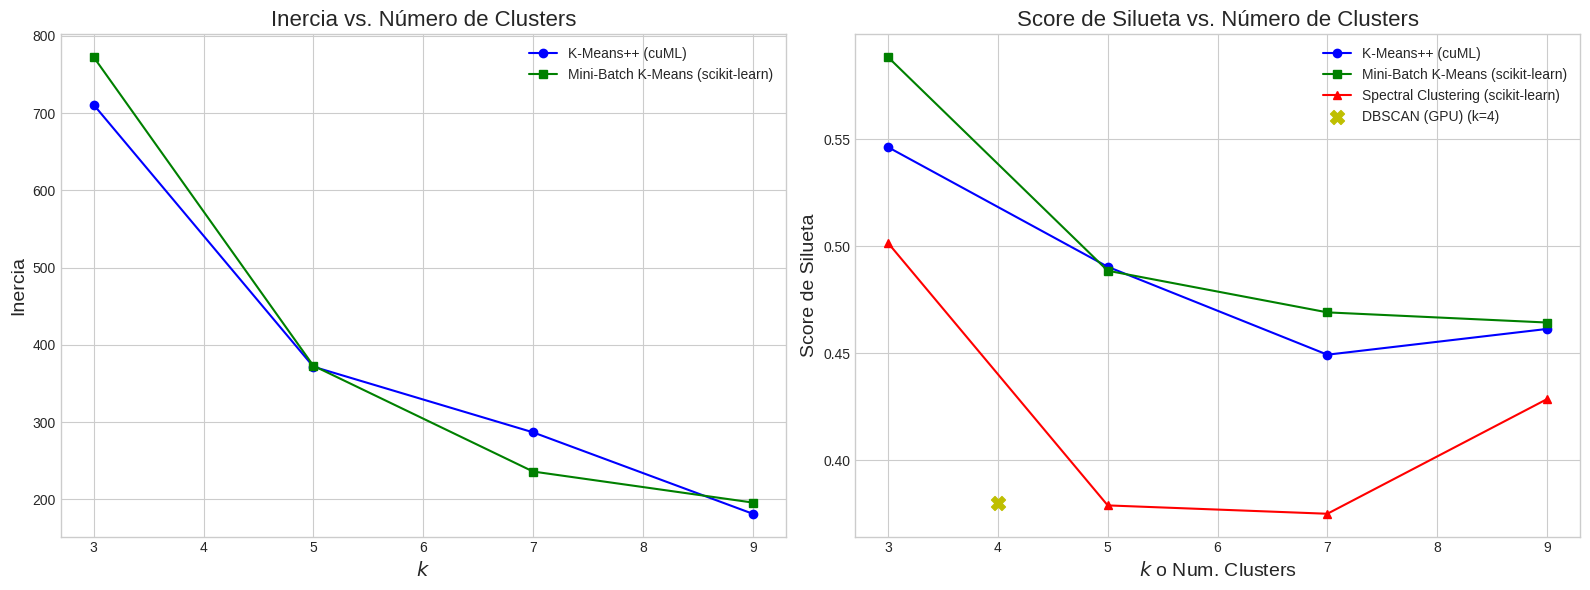

In [ ]:
# Asegúrate de que 'k_values' y 'results1' estén definidos y llenos.
# Por ejemplo:
# k_values = [3, 5, 7, 9]
# results1 = {
#     'K-Means++ (cuML)': {'inertia': [i1, i2, i3, i4], 'silhouette': [s1, s2, s3, s4]},
#     'Mini-Batch K-Means (scikit-learn)': {'inertia': [i5, i6, i7, i8], 'silhouette': [s5, s6, s7, s8]},
#     'Spectral Clustering (scikit-learn)': {'inertia': [None, None, None, None], 'silhouette': [s9, s10, s11, s12]},
#     'DBSCAN (cuML)': {'num_clusters': 6, 'silhouette': 0.55, 'time': '0.1234'}
# }

# Llamar a la función de visualización
plot_clustering_metrics(k_values, results1, dbscan_info=results1['DBSCAN (cuML)'])
#plot_clustering_metrics(k_values, results1, )

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_kmeans_k9.png


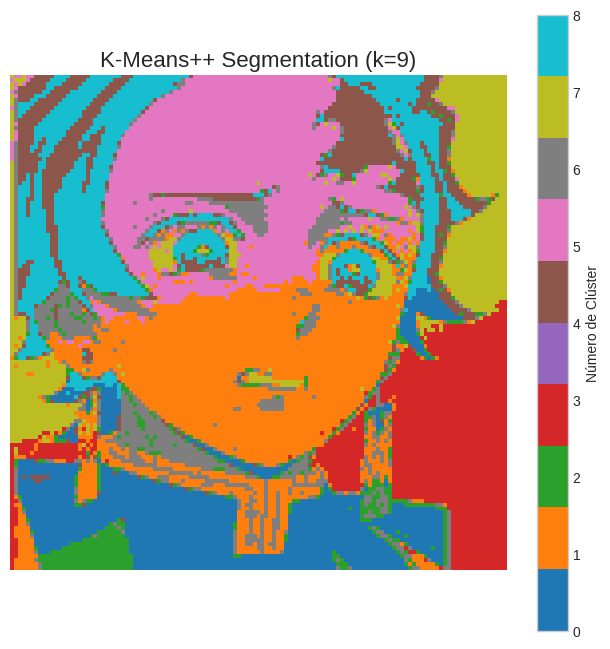

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_spectral_k9.png


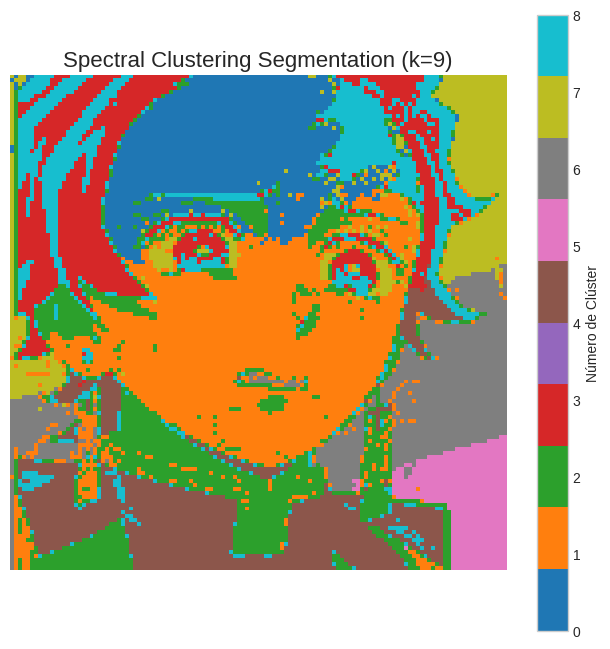

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_minibatch_k9.png


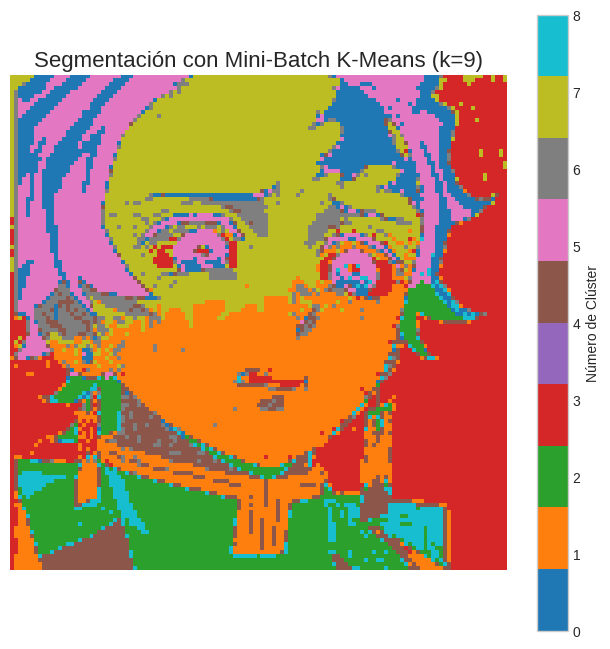

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_dbscan_clusters4.png


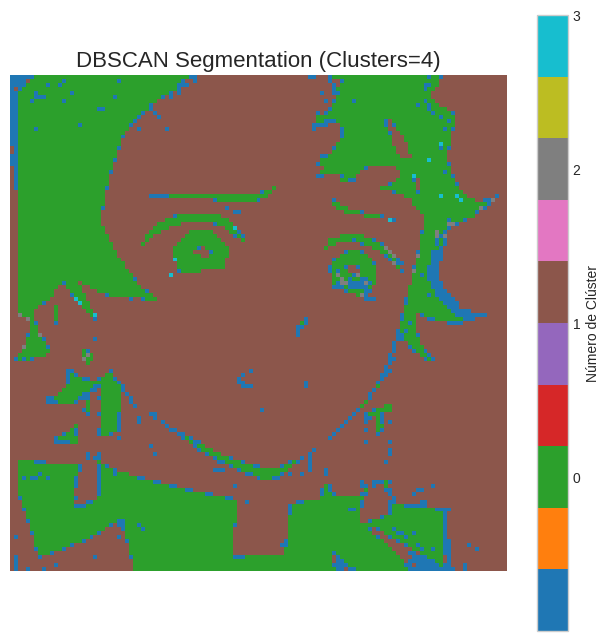


All segmentation images have been saved to the 'segmentaciones_finales_NORMALES1' folder and displayed.


In [ ]:
# --- Assuming you have img_rgb_original, height, width,
# --- and your trained models (kmeans_models, spectral_models, etc.) defined ---


# Define best k/number of clusters for each algorithm:
best_k_kmeans_plus_plus = 9 # Example
best_k_spectral = 9         # Example
best_k_minibatch = 9        # Example
# Correct the key to access DBSCAN results1from 'DBSCAN (cuML)' to 'DBSCAN_GPU'
best_k_dbscan_actual = results1['DBSCAN (cuML)']['num_clusters'] # Actual clusters found by DBSCAN

# Define the folder to save images
output_folder = "segmentaciones_finales_NORMALES1"
os.makedirs(output_folder, exist_ok=True) # Create the folder if it doesn't exist

# --- Calls to visualize_segmentation with save_path ---

# K-Means++ Segmentation
visualize_segmentation(
    model=kmeans_models[best_k_kmeans_plus_plus],
    title=f"K-Means++ Segmentation (k={best_k_kmeans_plus_plus})",
    k=best_k_kmeans_plus_plus,
    img_rgb_original=img_rgb, # Pass your original image data here
    height=height,            # Pass original image height
    width=width,              # Pass original image width
    save_path=os.path.join(output_folder, f"segmentation_kmeans_k{best_k_kmeans_plus_plus}.png")
)

# Spectral Clustering Segmentation
visualize_segmentation(
    model=spectral_models[best_k_spectral],
    title=f"Spectral Clustering Segmentation (k={best_k_spectral})",
    k=best_k_spectral,
    img_rgb_original=img_rgb,
    height=height,
    width=width,
    save_path=os.path.join(output_folder, f"segmentation_spectral_k{best_k_spectral}.png")
)

# Mini-Batch K-Means Segmentation
visualize_segmentation(
    model=minibatch_models[best_k_minibatch],
    title=f"Segmentación con Mini-Batch K-Means (k={best_k_minibatch})",
    k=best_k_minibatch,
    img_rgb_original=img_rgb,
    height=height,
    width=width,
    save_path=os.path.join(output_folder, f"segmentation_minibatch_k{best_k_minibatch}.png")
)

# DBSCAN Segmentation
visualize_segmentation(
    model=dbscan_model_result,
    title=f"DBSCAN Segmentation (Clusters={best_k_dbscan_actual})",
    k=best_k_dbscan_actual, # Use the actual number of clusters found by DBSCAN
    img_rgb_original=img_rgb,
    height=height,
    width=width,
    save_path=os.path.join(output_folder, f"segmentation_dbscan_clusters{best_k_dbscan_actual}.png")
)

print(f"\nAll segmentation images have been saved to the '{output_folder}' folder and displayed.")

## **U-MAP :**

In [ ]:
k_values = [3, 5, 7, 9]
results2 = {}

In [ ]:
# --- Asumiendo que X_reduced_pca_gpu y k_values ya están definidos de tu preparación de datos ---
# X_reduced_pca_gpu es tu DataFrame de cuDF con los datos escalados.
# k_values es tu lista de [3, 5, 7, 9].
# 'results2' es tu diccionario global para almacenar todos los resultados de los algoritmos.

# Llamada a la función para K-Means acelerado por cuML
kmeans_models, kmeans_inertia, kmeans_silhouette, kmeans_cuml_results2_entry = \
    train_and_evaluate_cuml_kmeans(X_reduced_umap_gpu, k_values, model_name="K-Means++ (cuML)")

# Añadir los resultados al diccionario global 'results2'
results2['K-Means++ (cuML)'] = kmeans_cuml_results2_entry

print("\nResultados de K-Means++ (cuML) añadidos al diccionario global 'results2'.")

# Puedes acceder a los scores así:
print(results2['K-Means++ (cuML)']['silhouette'])

Ejecutando K-Means++ (cuML)...
  Procesando para k = 3...
    k=3: Inercia=405282.00, Silueta=0.2728
  Procesando para k = 5...
    k=5: Inercia=293970.50, Silueta=0.3181
  Procesando para k = 7...
    k=7: Inercia=188679.11, Silueta=0.4110
  Procesando para k = 9...
    k=9: Inercia=148736.80, Silueta=0.4447

Resultados de K-Means++ (cuML) añadidos al diccionario global 'results2'.
[np.float32(0.27281302), np.float32(0.3180542), np.float32(0.41100922), np.float32(0.44473207)]


In [ ]:
# Llamada a la función para Mini-Batch K-Means de scikit-learn
minibatch_models, minibatch_inertia, minibatch_silhouette, minibatch_sklearn_results2_entry = \
    train_and_evaluate_sklearn_minibatch_kmeans(X_reduced_umap_gpu, k_values, model_name="Mini-Batch K-Means (scikit-learn)")

# Añadir los resultados al diccionario global 'results2'
results2['Mini-Batch K-Means (scikit-learn)'] = minibatch_sklearn_results2_entry

print("\nResultados de Mini-Batch K-Means (scikit-learn) añadidos al diccionario global 'results2'.")

# Puedes acceder a los scores así:
# print(results2['Mini-Batch K-Means (scikit-learn)']['silhouette'])

Ejecutando Mini-Batch K-Means (scikit-learn)...
  Procesando para k = 3...
    k=3: Inercia=436811.69, Silueta=0.2664
  Procesando para k = 5...
    k=5: Inercia=292922.44, Silueta=0.3342
  Procesando para k = 7...
    k=7: Inercia=213374.64, Silueta=0.4081
  Procesando para k = 9...
    k=9: Inercia=150293.27, Silueta=0.4459

Resultados de Mini-Batch K-Means (scikit-learn) añadidos al diccionario global 'results2'.


In [ ]:
# Llamada a la función para Spectral Clustering de scikit-learn TIEMPO APROX DE EJECUCION : 8 MINUTOS
spectral_models, spectral_silhouette, spectral_sklearn_results2_entry = \
    train_and_evaluate_sklearn_spectral(X_reduced_umap_gpu, k_values, model_name="Spectral Clustering (scikit-learn)")

# Añadir los resultados al diccionario global 'results2'
results2['Spectral Clustering (scikit-learn)'] = spectral_sklearn_results2_entry

print("\nResultados de Spectral Clustering (scikit-learn) añadidos al diccionario global 'results2'.")

# Puedes acceder a los scores así:
# print(results2['Spectral Clustering (scikit-learn)']['silhouette'])
# La inercia será una lista de [None, None, ...]
# print(results2['Spectral Clustering (scikit-learn)']['inertia'])

Ejecutando Spectral Clustering (scikit-learn)...
  Procesando para k = 3...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    k=3: Silueta=0.0684
  Procesando para k = 5...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    k=5: Silueta=-0.2302
  Procesando para k = 7...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    k=7: Silueta=-0.0228
  Procesando para k = 9...
    k=9: Silueta=-0.0160

Resultados de Spectral Clustering (scikit-learn) añadidos al diccionario global 'results2'.


In [ ]:
# Puedes definir tus valores para DBSCAN aquí o pasarlos como variables:
eps_val = 0.5 # Ajusta este valor para tu imagen
min_samples_val = 10 # Ajusta este valor

# Llamada a la función para DBSCAN (cuML)
dbscan_model_result, num_clusters_dbscan, silhouette_dbscan, time_dbscan, dbscan_cuml_results2_entry = \
    train_and_evaluate_cuml_dbscan(X_reduced_umap_gpu, eps_val, min_samples_val, model_name="DBSCAN (cuML)")

# Añadir los resultados al diccionario global 'results2'
results2['DBSCAN (cuML)'] = dbscan_cuml_results2_entry

print("\nResultados de DBSCAN (cuML) añadidos al diccionario global 'results2'.")

# Puedes acceder a los scores así:
print(results2['DBSCAN (cuML)']['silhouette'])
print(results2['DBSCAN (cuML)']['num_clusters'])


Ejecutando DBSCAN (cuML) (eps=0.5, min_samples=10)...
    Num clusters (excl. ruido): 25, Silueta: 0.1217, Tiempo: 3.9633s

Resultados de DBSCAN (cuML) añadidos al diccionario global 'results2'.
0.12169264
25


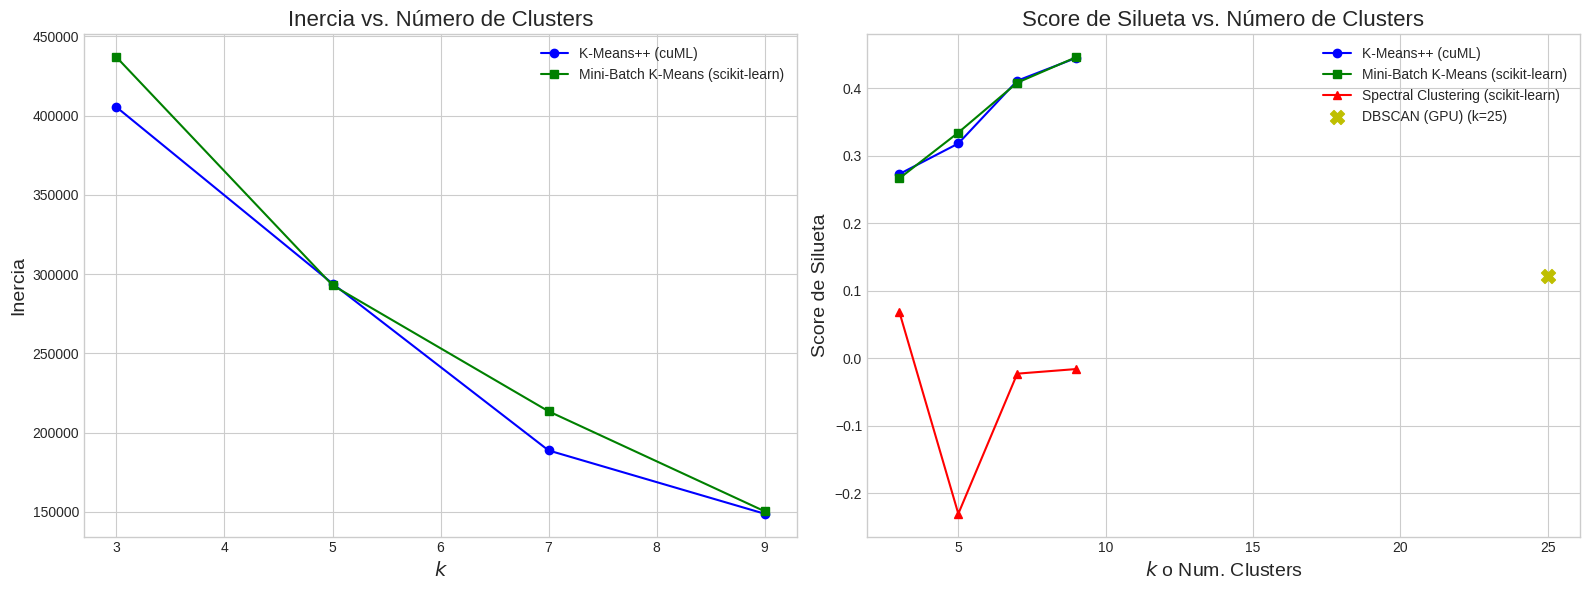

In [ ]:
# Asegúrate de que 'k_values' y 'results2' estén definidos y llenos.
# Llamar a la función de visualización
plot_clustering_metrics(k_values, results2, dbscan_info=results2['DBSCAN (cuML)'])
#plot_clustering_metrics(k_values, results2, )

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_kmeans_k9.png


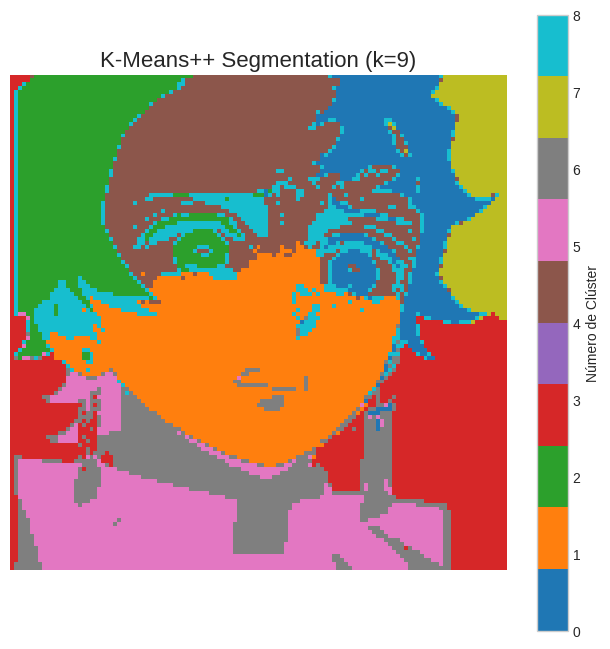

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_spectral_k9.png


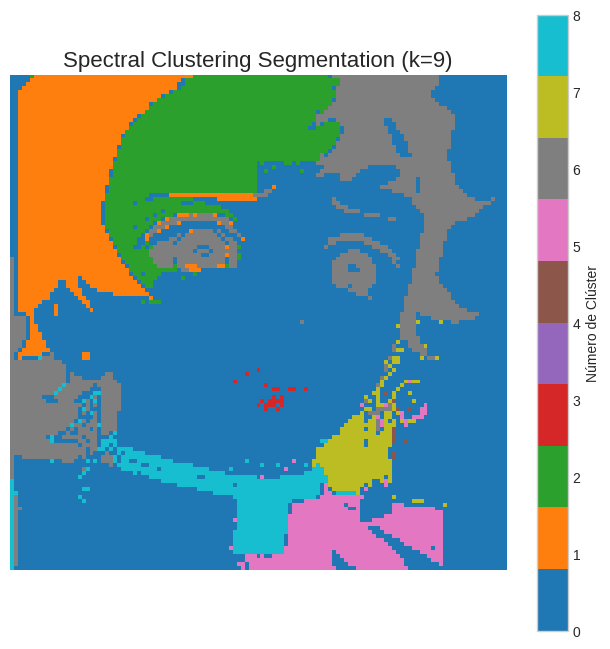

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_minibatch_k9.png


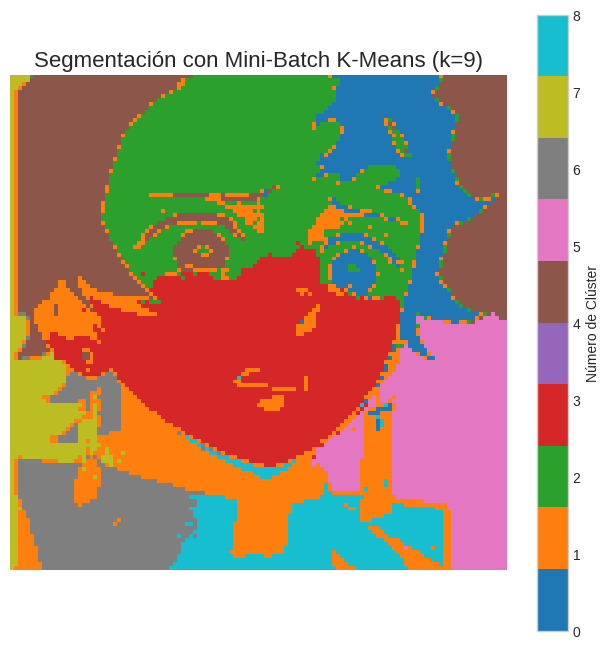

Segmentación guardada en: segmentaciones_finales_NORMALES1/segmentation_dbscan_clusters25.png


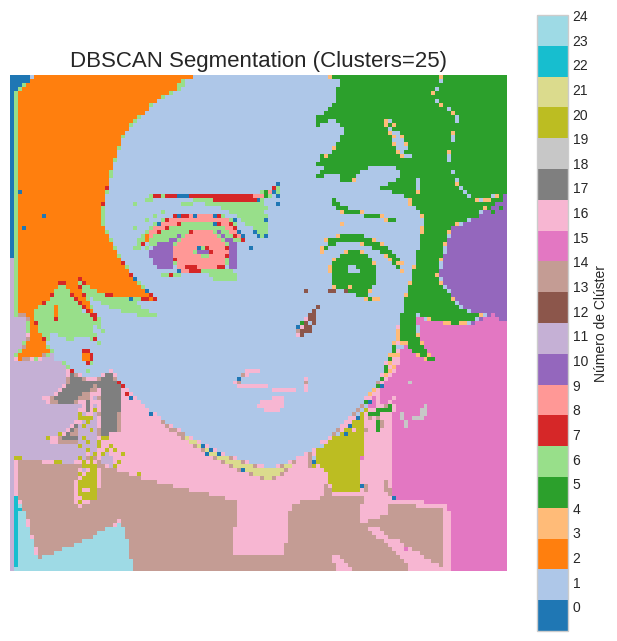


All segmentation images have been saved to the 'segmentaciones_finales_NORMALES1' folder and displayed.


In [ ]:
# --- Assuming you have img_rgb_original, height, width,
# --- and your trained models (kmeans_models, spectral_models, etc.) defined ---

# Define best k/number of clusters for each algorithm:
best_k_kmeans_plus_plus = 9 # Example
best_k_spectral = 9         # Example
best_k_minibatch = 9       # Example
# Correct the key to access DBSCAN results1from 'DBSCAN (cuML)' to 'DBSCAN_GPU'
best_k_dbscan_actual = results2['DBSCAN (cuML)']['num_clusters'] # Actual clusters found by DBSCAN

# Define the folder to save images
output_folder = "segmentaciones_finales_NORMALES1"
os.makedirs(output_folder, exist_ok=True) # Create the folder if it doesn't exist

# --- Calls to visualize_segmentation with save_path ---

# K-Means++ Segmentation
visualize_segmentation(
    model=kmeans_models[best_k_kmeans_plus_plus],
    title=f"K-Means++ Segmentation (k={best_k_kmeans_plus_plus})",
    k=best_k_kmeans_plus_plus,
    img_rgb_original=img_rgb, # Pass your original image data here
    height=height,            # Pass original image height
    width=width,              # Pass original image width
    save_path=os.path.join(output_folder, f"segmentation_kmeans_k{best_k_kmeans_plus_plus}.png")
)

# Spectral Clustering Segmentation
visualize_segmentation(
    model=spectral_models[best_k_spectral],
    title=f"Spectral Clustering Segmentation (k={best_k_spectral})",
    k=best_k_spectral,
    img_rgb_original=img_rgb,
    height=height,
    width=width,
    save_path=os.path.join(output_folder, f"segmentation_spectral_k{best_k_spectral}.png")
)

# Mini-Batch K-Means Segmentation
visualize_segmentation(
    model=minibatch_models[best_k_minibatch],
    title=f"Segmentación con Mini-Batch K-Means (k={best_k_minibatch})",
    k=best_k_minibatch,
    img_rgb_original=img_rgb,
    height=height,
    width=width,
    save_path=os.path.join(output_folder, f"segmentation_minibatch_k{best_k_minibatch}.png")
)

# DBSCAN Segmentation
visualize_segmentation(
    model=dbscan_model_result,
    title=f"DBSCAN Segmentation (Clusters={best_k_dbscan_actual})",
    k=best_k_dbscan_actual, # Use the actual number of clusters found by DBSCAN
    img_rgb_original=img_rgb,
    height=height,
    width=width,
    save_path=os.path.join(output_folder, f"segmentation_dbscan_clusters{best_k_dbscan_actual}.png")
)

print(f"\nAll segmentation images have been saved to the '{output_folder}' folder and displayed.")